In [3]:
import time
from collections import OrderedDict
def uint32(v): return (v & 0xFFFFFFFF)
def uint40(v): return (v & 0xFFFFFFFFFF)

def warn(msg):
    print("WARNING", msg)

class Register:
    def __init__(self, number, hardware_name, assembly_name, bits):
        self.number = number
        self.name = hardware_name
        self.hardware_name = hardware_name
        self.assembly_name = assembly_name
        self.bits = bits
        self.data = [0] * (bits // 8)

    def copy(self, src, offset=0):
        for i,s in enumerate(src):
            self.data[i+offset] = s
            
    def __str__(self):
        if self.number >= 0:
            r = f"{self.assembly_name} [{self.hardware_name}={self.number}]"
        elif self.hardware_name != self.assembly_name and self.assembly_name is not None:
            r = f"{self.assembly_name} [{self.hardware_name}]"
        else:
            r = self.hardware_name
        return r + " " + str(self.data)
        
    @property
    def int(self):
        v = self.uint
        if v & (1<<(self.bits-1)): #0x80000000:
            v -= 1<<self.bits
        return v

    @int.setter
    def int(self, value):
        if value < -(1<<self.bits-1):
            warn("value < min when setting int" + str(self.bits))
        if value >= 1 << (self.bits-1):
            warn("value > max when setting int" + str(self.bits))
        for i in range(len(self.data)):
            self.data[i] = (value >> (i<<3)) & 0xFF
            
        v = value 
    
    @property
    def uint(self):
        return sum(d << (i << 3) for i,d in enumerate(self.data)) 

    @uint.setter
    def uint(self, value):
        if value < 0:
            warn("value < min when setting uint" + str(self.bits))
        if value >= 1 << self.bits:
            warn("value > max when setting uint" + str(self.bits))
        for i in range(len(self.data)):
            self.data[i] = (value >> (i<<3)) & 0xFF

    @property
    def u8vec(self):
        return self.data

    @u8vec.setter
    def u8vec(self, value):
        self.copy(value)

    @property
    def s8vec(self):
        s8 = []
        for i in range(0,len(self.data)):
            v = self.data[i]
            if v & 0x80: v = v - 256
            s8.append(v)
        return s8
        
    @s8vec.setter
    def s8vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
        self.copy(u8)

    @property
    def u16vec(self):
        u16 = []
        for i in range(0,len(self.data), 2):
            l = self.data[i]
            h = self.data[i+1]
            u16.append(l | (h << 8))
        return u16
        
    @u16vec.setter
    def u16vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
            u8.append((v >> 8) & 0xFF)
        self.copy(u8)

    @property
    def s16vec(self):
        s16 = []
        for i in range(0,len(self.data), 2):
            l = self.data[i]
            h = self.data[i+1]
            v = l | (h << 8)
            if v & 0x8000: v -= 65536
            s16.append(v)
        return s16
        
    @s16vec.setter
    def s16vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
            u8.append((v >> 8) & 0xFF)
        self.copy(u8)

    @property
    def s20vec(self):
        s20 = []
        for i in range(0,len(self.data), 5):
            ll = self.data[i]
            lh = self.data[i+1]
            hl = self.data[i+2]
            hh = self.data[i+3]
            hhh = self.data[i+4]
            v = ll | (lh << 8) | (hl << 16) | (hh << 24) | (hhh << 32)
            v0 = v & 0xFFFFF
            v1 = (v >> 20) & 0xFFFFF
            if v0 & 0x80000: v0 -= 1<<20
            if v1 & 0x80000: v1 -= 1<<20
            s20.append(v0)
            s20.append(v1)
        return s20
        
    @s20vec.setter
    def s20vec(self, value):
        u8 = []
        for i in range(len(value)):
            u8.append(v0 & 0xFF)
            u8.append((v0 >> 8) & 0xFF)
            u8.append(((v0 >> 16) & 0xF) | ((v1 << 4) & 0xF0))
            u8.append((v1 >> 4) & 0xFF)
            u8.append((v1 >> 12) & 0xFF)
        self.copy(u8)

    @property
    def u20vec(self):
        u20 = []
        for i in range(0,len(self.data), 5):
            ll = self.data[i]
            lh = self.data[i+1]
            hl = self.data[i+2]
            hh = self.data[i+3]
            hhh = self.data[i+4]
            v = ll | (lh << 8) | (lh << 16) | (hh << 24) | (hhh << 32)
            v0 = v & 0xFFFFF
            v1 = (v >> 20) & 0xFFFFF
            s20.append(v0)
            s20.append(v1)
        return s20
        
    @u20vec.setter
    def u20vec(self, value):
        u8 = []
        for i in range(len(value)):
            u8.append(v0 & 0xFF)
            u8.append((v0 >> 8) & 0xFF)
            u8.append(((v0 >> 16) & 0xF) | ((v1 << 4) & 0xF0))
            u8.append((v1 >> 4) & 0xFF)
            u8.append((v1 >> 12) & 0xFF)
        self.copy(u8)

    @property
    def u32vec(self):
        u32 = []
        for i in range(0,len(self.data), 4):
            ll = self.data[i]
            lh = self.data[i+1]
            hl = self.data[i+2]
            hh = self.data[i+3]
            u32.append(ll | (lh << 8) | (hl << 16) | (hh << 24))
        return u32
        
    @u32vec.setter
    def u32vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
            u8.append((v >> 8) & 0xFF)
            u8.append((v >> 16) & 0xFF)
            u8.append((v >> 24) & 0xFF)
        self.copy(u8)

    @property
    def s32vec(self):
        s32 = []
        for i in range(0,len(self.data), 4):
            ll = self.data[i]
            lh = self.data[i+1]
            hl = self.data[i+2]
            hh = self.data[i+3]
            v = ll | (lh << 8) | (hl << 16) | (hh << 24)
            if v & 0x80000000: v -= 1<<32
            s32.append(v)
        return s32
        
    @s32vec.setter
    def s32vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
            u8.append((v >> 8) & 0xFF)
            u8.append((v >> 16) & 0xFF)
            u8.append((v >> 24) & 0xFF)
        self.copy(u8)

    @property
    def u40vec(self):
        u40 = []
        for i in range(0,len(self.data), 5):
            ll = self.data[i]
            lh = self.data[i+1]
            hl = self.data[i+2]
            hh = self.data[i+3]
            hhh = self.data[i+4]
            u40.append(ll | (lh << 8) | (hl << 16) | (hh << 24) | (hhh << 32))
        return u40
        
    @u40vec.setter
    def u40vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
            u8.append((v >> 8) & 0xFF)
            u8.append((v >> 16) & 0xFF)
            u8.append((v >> 24) & 0xFF)
            u8.append((v >> 32) & 0xFF)
        self.copy(u8)

    @property
    def s40vec(self):
        s40 = []
        for i in range(0,len(self.data), 5):
            ll = self.data[i]
            lh = self.data[i+1]
            hl = self.data[i+2]
            hh = self.data[i+3]
            hhh = self.data[i+4]
            v = ll | (lh << 8) | (hl << 16) | (hh << 24) | (hhh << 32)
            if v & 0x8000000000: v -= 1<<40
            s40.append(v)
        return s40
        
    @s40vec.setter
    def s40vec(self, value):
        u8 = []
        for v in value:
            u8.append(v & 0xFF)
            u8.append((v >> 8) & 0xFF)
            u8.append((v >> 16) & 0xFF)
            u8.append((v >> 24) & 0xFF)
            u8.append((v >> 32) & 0xFF)
        self.copy(u8)

class InstructionFormat(OrderedDict):
    def __init__(self, name="---"):
        if name == "RRR": super().__init__(dict(op2=4, op1=4, r=4, s=4, t=4, op0=4))
        elif name == "RRI4": super().__init__(dict(imm4=4, op1=4, r=4, s=4, t=4, op0=4))
        elif name == "RRI8": super().__init__(dict(imm8=8, r=4, s=4, t=4, op0=4))
        elif name == "RI16": super().__init__(dict(imm16=16, t=4, op0=4))
        elif name == "RSR": super().__init__(dict(op2=4, op1=4, rs=8, t=4, op0=4))
        elif name == "CALL": super().__init__(dict(ofset=18, n=2, op0=4))
        elif name == "CALLX": super().__init__(dict(op2=4, op1=4, r=4, s=4, m=2, n=2, op0=4))
        elif name == "BRI8": super().__init__(dict(imm8=8, r=4, s=4, m=2, n=2, op0=4))
        elif name == "BRI12": super().__init__(dict(imm12=12, s=4, m=2, n=2, op0=4))
        elif name == "RRRN": super().__init__(dict(r=4, s=4, t=4, op0=4))
        elif name == "RI7": super().__init__(dict(imm7_l=4,s=4, i_imm7_h=4, op0=4))
        elif name == "RI6": super().__init__(dict(imm6_l=4, s=4, i_z_imm6_h=4, op0=4))
        else: super().__init__(dict(op0=24))
        self.name = name

class InstructionDescriptor(object):
    def __init__(self, template, format, description):
        self.template = template
        self.name, *argument_names = template.split(" ",1)
        self.argument_names = argument_names[0].replace(" ","").split(",") if argument_names else []
        self.format = format
        self.description = description
        
    def __str__(self):
        return "[" + ", ".join(self.argument_names) + "] " + self.description

class Instruction(object):
    def __init__(self, context, address, descriptor, arguments, comments):
        self.context = context
        self.address = address
        self.descriptor = descriptor
        self.arguments = arguments
        self.comments = comments
        
        if descriptor.name.startswith("!"):
            self.size = 0 
            self.virtual = True
        elif descriptor.name.endswith(".N"):
            self.size = 2
            self.virtual = False
        else:
            self.size = 3
            self.virtual = False
            
    @classmethod
    def parse(cls, context, address, line):
        line, *comments = line.split("#")
        line = line.strip()
        comments = [c.strip() for c in comments]
        
        if ":" in line:
            name = "!LABEL"
            arguments = [line.split(":")[0]]
        else:
            name, *arguments = line.split(" ",1)
            arguments = arguments[0] if arguments else ""
            arguments = arguments.replace(" ","").split(",")
            if len(arguments) == 1 and not len(arguments[0]): arguments = []
        descriptor = context.find_instruction(name.upper())
        return cls(context, address, descriptor, arguments, comments)

    def execute(self):
        i = self.context
        fn = "_" + self.descriptor.name.lower().replace(".","_").replace("!","")
        if not hasattr(i, fn):
            for o in self.context.options.values():
                if hasattr(o, fn): 
                    i=o
                    break
        assert hasattr(i, fn)
        cb = getattr(i, fn)
        assert callable(cb)
        cb(*self.arguments)
            
    def __str__(self):
        line = " ".join((self.descriptor.name, ", ".join(self.arguments)))
        return line + (" " * (32-len(line)) if len(line) < 32 else " ") #+ "# " + str(self.descriptor)


class InstructionSet(object):
    def __init__(self, name=""):
        self.name = name
        self.parent = None
        self.register = {}
        self.instructions = {}
            
        self.expansions = {}
        self.endianness = "le"
        self.options = {}
        self.labels = {}
        self.program = []
        self.wptr = 0
        self.vpc = 0
        self.last_label = None
        self.last_echo_time = None
        self.icnt = 0

    def echo(self, instr=None, end="\n"):
        self.last_echo_time = time.time()
        label = self.last_label or "[N/A]"
        instr = instr or "---"
        print(f"\033[1;36m[{self.icnt}] \033[1;33m{label} \033[0;37m{instr}", end=" " * 16 + end)
        
    def add_code(self, code):
        for line in code.split("\n"):
            line = line.strip()
            if not line: continue
            i = Instruction.parse(self, self.wptr, line)
            self.program.append(i)
            if i.descriptor.name == "!LABEL":
                self.labels[i.arguments[0]] = self.wptr
            self.wptr += i.size
            
    def step(self):
        pc = self.find_register("PC").uint
        assert self.vpc < len(self.program)
        instr = self.program[self.vpc]
        self.vpc += 1
        pc += instr.size
        self.find_register("PC").uint = pc
        instr.execute()
        self.icnt += 1
        if instr.descriptor.name == "!LABEL":
            self.last_label = instr.arguments[0]
        elif not self.last_echo_time or time.time() - self.last_echo_time > 0.3:
            self.echo(instr, end="\r")
            
        next_pc = self.find_register("PC").uint
        if next_pc != pc:
            for i, instr in enumerate(self.program):
                if instr.address == next_pc:
                    self.vpc = i
                    break
            else:
                raise RuntimeException("No instruction at PC")        
    
    def find_instruction(self, instruction):
        while isinstance(instruction,str):
            name = instruction
            if name not in self.instructions and self.parent is not None:
                return self.parent.find_instruction(name)
            instruction = self.instructions[name]
            if isinstance(instruction, InstructionSetOption):
                return instruction.find_instruction(name)
        assert isinstance(instruction, InstructionDescriptor)
        return instruction


    def find_register(self, register):
        while isinstance(register, str):
            name = register
            if name not in self.registers and self.parent is not None:
                return self.parent.find_register(name)
            register = self.registers[name]
            if isinstance(register, InstructionSetOption):
                return register.find_register(name)
        assert isinstance(register, Register)
        return register
        
    def extend(self, option):
        option.parent = self
        self.options[option.name] = option
        
        for r in option.registers:
            if r in self.registers:
                if not isinstance(option, WindowedRegisterOption):
                    print(f"WARNING. {option} overwrites register {r}")
            self.registers[r] = option #.registers[r]
        for i in option.instructions:
            if i in self.instructions:
                print(f"WARNING. {option} overwrites instruction {i}")
            self.instructions[i] = option #.instructions[i]

        
class InstructionSetOption(InstructionSet): ...
class CoreInstructionSet(InstructionSet): 
    def __init__(self):
        super().__init__("core")
        self.registers = {
            "AR0": Register(0, "AR0", "a0", 32),
            "AR1": Register(1, "AR1", "a1", 32),
            "AR2": Register(2, "AR2", "a2", 32),
            "AR3": Register(3, "AR3", "a3", 32),
            "AR4": Register(4, "AR4", "a4", 32),
            "AR5": Register(5, "AR5", "a5", 32),
            "AR6": Register(6, "AR6", "a6", 32),
            "AR7": Register(7, "AR7", "a7", 32),
            "AR8": Register(8, "AR8", "a8", 32),
            "AR9": Register(9, "AR9", "a9", 32),
            "AR10": Register(10, "AR10", "a10", 32),
            "AR11": Register(11, "AR11", "a11", 32),
            "AR12": Register(12, "AR12", "a12", 32),
            "AR13": Register(13, "AR13", "a13", 32),
            "AR14": Register(14, "AR14", "a14", 32),
            "AR15": Register(15, "AR15", "a15", 32),
            "a0": "AR0",
            "a1": "AR1",
            "a2": "AR2",
            "a3": "AR3",
            "a4": "AR4",
            "a5": "AR5",
            "a6": "AR6",
            "a7": "AR7",
            "a8": "AR8",
            "a9": "AR9",
            "a10": "AR10",
            "a11": "AR11",
            "a12": "AR12",
            "a13": "AR13",
            "a14": "AR14",
            "a15": "AR15",
            "PC": Register(-1, "PC", "PC", 32),
            "SAR": Register(-1, "SAR","SAR", 8),    
        }

        self.instructions = {
            "LABEL": InstructionDescriptor("LABEL label", InstructionFormat(), ""),
            "L8UI": InstructionDescriptor("L8UI at, as, 0..255", InstructionFormat("RRI8"), "8-bit unsigned load (8-bit offset)"),
            "L16SI": InstructionDescriptor("L16SI at, as, 0..510", InstructionFormat("RRI8"), "16-bit signed load (8-bit shifted offset)"),
            "L16UI": InstructionDescriptor("L16UI at, as, 0..510", InstructionFormat("RRI8"), "16-bit unsigned load (8-bit shifted offset)"),
            "L32I": InstructionDescriptor("L32I at, as, 0..1020", InstructionFormat("RRI8"), "32-bit load (8-bit shifted offset)"),
            "L32R": InstructionDescriptor("L32R at, label", InstructionFormat("RI16"), "32-bit load PC-relative (16-bit negative word offset)"),
            "S8I": InstructionDescriptor("S8I at, as, 0..255", InstructionFormat("RRI8"), "8-bit store (8-bit offset)"),
            "S16I": InstructionDescriptor("S16I at, as, 0..510", InstructionFormat("RRI8"), "16-bit store (8-bit shifted offset)"),
            "S32I": InstructionDescriptor("S32I at, as, 0..1020", InstructionFormat("RRI8"), "32-bit store (8-bit shifted offset)"),
            "MEMW": InstructionDescriptor("MEMW", InstructionFormat("RRR"), "Order memory accesses before with memory access after"),
            "EXTW": InstructionDescriptor("EXTW", InstructionFormat("RRR"), "Order all external effects before with all external effects after"),
            "CALLO": InstructionDescriptor("CALL0 label", InstructionFormat("CALL"), "Call subroutine, PC-relative"),
            "CALLX0": InstructionDescriptor("CALLX0 label", InstructionFormat("CALLX"), "Call subroutine, address in register"),
            "RET": InstructionDescriptor("RET", InstructionFormat("CALLX"), "Subroutine return -- jump to return address"),
            "J": InstructionDescriptor("J label", InstructionFormat("CALLX"),"Unconditional jump, PC-relative"),
            "JX": InstructionDescriptor("JX as", InstructionFormat("CALLX"), "Unconditional jump, address in register"),
            "BALL": InstructionDescriptor("BALL as, at, label", InstructionFormat("RRI8"), "Branch if all of the masked bits are set"),
            "BNALL": InstructionDescriptor("BNALL as, at, label", InstructionFormat("RRI8"),"Branch if not all of the masked bits are set"),
            "BANY": InstructionDescriptor("BANY as, at, label", InstructionFormat("RRI8"), "Branch if any of the masked bits are set"),
            "BNONE": InstructionDescriptor("BNONE as, at, label", InstructionFormat("RRI8"), "Branch if none of the masked bits are set (All Clear)"),
            "BBC": InstructionDescriptor("BBC as, at, label", InstructionFormat("RRI8"), "Branch if bit clear"),
            "BBCI": InstructionDescriptor("BBCI as, 0..31, label", InstructionFormat("RRI8"), "Branch if bit clear immediate"),
            "BBS": InstructionDescriptor("BBS as, at, label", InstructionFormat("RRI8"), "Branch if bit set"),
            "BBSI": InstructionDescriptor("BBSI as, 0..31, label", InstructionFormat("RRI8"), "Branch is bit set immediate"),
            "BEQ": InstructionDescriptor("BEQ as, at, label", InstructionFormat("RRI8"), "Branch if equal"),
            "BEQI": InstructionDescriptor("BEQI as, imm, label", InstructionFormat("BRI8"), "Branch if equal immediate"),
            "BEQZ": InstructionDescriptor("BEQZ as, label", InstructionFormat("BRI12"), "Branch is equal to zero"),
            "BNE": InstructionDescriptor("BNE as, at, label", InstructionFormat("RRI8"), "Branch if not equal"),
            "BNEI": InstructionDescriptor("BNEI as, imm, label", InstructionFormat("BRI8"), "Branch if not equal to immediate"),
            "BNEZ": InstructionDescriptor("BNEZ as, label", InstructionFormat("BRI12"), "Branch if not equal to zero"),
            "BGE": InstructionDescriptor("BGE as, at, label", InstructionFormat("RRI8"), "Branch if greater than or equal"),
            "BGEI": InstructionDescriptor("BGEI as, imm, label", InstructionFormat("BRI8"),"Branch if greater than or equal to immediate"),
            "BGEU": InstructionDescriptor("BGEU as, at, label", InstructionFormat("RRI8"), "Branch if greater than or equal unsigned"),
            "BGEUI": InstructionDescriptor("BGEUI as, imm, label", InstructionFormat("BRI8"), "Branch if greater than or equal to unsigned immediate"),
            "BGEZ": InstructionDescriptor("BGEZ as, label", InstructionFormat("BRI12"), "Branch to greater than or equal to zero"),
            "BLT": InstructionDescriptor("BLT as, at, label", InstructionFormat("RRI8"),"Branch if less than"),
            "BLTI": InstructionDescriptor("BLTI as, imm, label", InstructionFormat("BRI8"), "Branch if less than immediate"),
            "BLTU": InstructionDescriptor("BLTU as, at, label", InstructionFormat("RRI8"), "Branch if less than unsigned"),
            "BLTUI": InstructionDescriptor("BLTUI as, imm, label", InstructionFormat("BRI8"), "Branch if less than unsigned immediate"),
            "BLTZ": InstructionDescriptor("BLTZ as, label", InstructionFormat("RRI8"), "Branch if less than zero"),
            "MOVI": InstructionDescriptor("MOVI at, -2048..2047", InstructionFormat("RRI8"), "Load register with 12-bit signed constant"),
            "MOVEQZ": InstructionDescriptor("MOVEQZ ar, as, at", InstructionFormat("RRR"), "Conditional move if zero"),
            "MOVNEZ": InstructionDescriptor("MOVNEZ ar, as, at", InstructionFormat("RRR"), "Conditional move if non-zero"),
            "MOVLTZ": InstructionDescriptor("MOVLTZ ar, as, at", InstructionFormat("RRR"), "Conditional move if less than zero"),
            "MOVGEZ": InstructionDescriptor("MOVGEZ ar, as, at", InstructionFormat("RRR"), "Conditional move if greater than or equal to zero"),
            "ADD": InstructionDescriptor("ADD ar, as, at", InstructionFormat("RRR"), "Add two registers"),
            "ADDI": InstructionDescriptor("ADDI at, as, -128..127", InstructionFormat("RRI8"), "Add signed constant to register"),
            "ADDMI": InstructionDescriptor("ADDMI at, as, -32768..32512", InstructionFormat("RRI8"), "Add signed constant shifted by 8 to register"),
            "ADDX2": InstructionDescriptor("ADDX2 ar, as, at", InstructionFormat("RRR"), "Add register to register shifted by 1"),
            "ADDX4": InstructionDescriptor("ADDX4 ar, as, at", InstructionFormat("RRR"), "Add register to register shifted by 2"),
            "ADDX8": InstructionDescriptor("ADDX8 ar, as, at", InstructionFormat("RRR"), "Add register to register shifted by 3"),
            "SUB": InstructionDescriptor("SUB ar, as, at", InstructionFormat("RRR"), "Subtract two registers"),
            "SUBX2": InstructionDescriptor("SUBX2 ar, as, at", InstructionFormat("RRR"), "Subtract register from register shifted by 1"),
            "SUBX4": InstructionDescriptor("SUBX4 ar, as, at", InstructionFormat("RRR"), "Subtract register from register shifted by 2"),
            "SUBX8": InstructionDescriptor("SUBX8 ar, as, at", InstructionFormat("RRR"), "Subtract register from register shifted by 3"),
            "NEG": InstructionDescriptor("NEG ar, at", InstructionFormat("RRR"), "Negate"),
            "ABS": InstructionDescriptor("ABS ar, at", InstructionFormat("RRR"), "Absolute value"),
            "SALT": InstructionDescriptor("SALT ar, as, at", InstructionFormat("RRR"), "Set AR if less than"),
            "SALTU": InstructionDescriptor("SALTU ar, as, at", InstructionFormat("RRR"), "Set AR if less than unsigned"),
            "AND": InstructionDescriptor("AND ar, as, at", InstructionFormat("RRR"), "Bitwise logical and"),
            "OR": InstructionDescriptor("OR ar, as, at", InstructionFormat("RRR"), "Bitwise logical or"),
            "XOR": InstructionDescriptor("XOR ar, as, at", InstructionFormat("RRR"), "Bitwise logical xor"),
            "EXTUI": InstructionDescriptor("EXTUI ar, at, shiftimm, maskimm", InstructionFormat("RRR"), "Extract unsigned field immediate"),
            "SRLI": InstructionDescriptor("SRLI ar, at, 0..15", InstructionFormat("RRR"), "Shift right logical immediate"),
            "SRAI": InstructionDescriptor("SRAI ar, at, 0..15", InstructionFormat("RRR"), "Shift right arithmetic immediate"),
            "SLLI": InstructionDescriptor("SLLI ar, at, 0..15", InstructionFormat("RRR"), "Shift left logical immediate"),
            "SRC": InstructionDescriptor("SRC ar, as, at", InstructionFormat("RRR"), "Shift right combined"),
            "SLL": InstructionDescriptor("SLL ar, at", InstructionFormat("RRR"), "Shift left logical"),
            "SRL": InstructionDescriptor("SRL ar, at", InstructionFormat("RRR"), "Shift right logical"),
            "SRA": InstructionDescriptor("SRA ar, at", InstructionFormat("RRR"), "Shift right arithmetic"),
            "SSL": InstructionDescriptor("SSL as", InstructionFormat("RRR"), "Set shift amount register for shift left logical"),
            "SSR": InstructionDescriptor("SSR as", InstructionFormat("RRR"), "Set shift amount register for shift right logical"),
            "SSAI":InstructionDescriptor("SRAI ar, at, 0..31", InstructionFormat("RRR"), "Set shift amount register immediate"),
            "SSA8B":InstructionDescriptor("SSA8B as", InstructionFormat("RRR"), "Set shift amount register for big-endian byte align"),
            "SSA8L": InstructionDescriptor("SSA8L as", InstructionFormat("RRR"), "Set shift amount register for little-endian byte align"),
            "RSR": InstructionDescriptor("RSR ar, sr", InstructionFormat("RSR"), "Read special register"),
            "WSR": InstructionDescriptor("WSR at, sr", InstructionFormat("RSR"), "Write special register"),
            "XSR": InstructionDescriptor("XSR at, sr", InstructionFormat("RSR"), "Exchange special register"),
            "RUR": InstructionDescriptor("RUR ar, sr", InstructionFormat("RUR"), "Read user defined register"),
            "WUR": InstructionDescriptor("WUR at, sr", InstructionFormat("RUR"), "Write user defined register"),
            "ISYNC": InstructionDescriptor("ISYNC", InstructionFormat("RRR"), "Instruction fetch synchronize"),
            "RSYNC": InstructionDescriptor("RSYNC", InstructionFormat("RRR"), "Instruction register synchronize"),
            "ESYNC": InstructionDescriptor("ESYNC", InstructionFormat("RRR"), "Register value synchronize"),
            "DSYNC": InstructionDescriptor("DSYNC", InstructionFormat("RRR"), "Load/store synchronize"),
            "FSYNC": InstructionDescriptor("FSYNC", InstructionFormat("RRR"), "Fetch synchronize"),
            "NOP": InstructionDescriptor("NOP", InstructionFormat("RRR"), "No operation"),
            "ILL": InstructionDescriptor("ILL", InstructionFormat("RRR"), "Illegal instruction"),
            "!DUMP": InstructionDescriptor("!DUMP *ar", InstructionFormat(), "Emulator dump register"),
            "!DUMPX": InstructionDescriptor("!DUMPX *ar", InstructionFormat(), "Emulator dump register in hex format"),
            "!DUMPS": InstructionDescriptor("!DUMPS *ar", InstructionFormat(), "Emulator dump register in signed format"),
            "!DUMPU": InstructionDescriptor("!DUMPU *ar", InstructionFormat(), "Emulator dump register in unsigned format"),
            "!LABEL": InstructionDescriptor("!LABEL label", InstructionFormat(), "Label declaration (virtual)")
        }

        self.b4const = [-1,1,2,3,4,5,6,7,8,10,12,16,32,64,128,256]
        self.b4constu = [32768, 65536, 2,3,4,5,6,7,8,10,12,16,32,64,128,256]
        self.memory = [0] * (1<<23) # 8MB

    def _label(self, label):
        #print("Passing label", label)
        pass
        
    def _dump(self, *regs):
        for r in regs:
            print(r+":", self.find_register(r).data, end=" ")
        print()
        
    def _dumpx(self, *regs):
        for r in regs:
            print(r+":", "".join(f"{byte:02X}" for byte in reversed(self.find_register(r).data)), end=" ")
        print()
        
    def _dumpu(self, *regs):
        for r in regs:
            print(r+":", self.find_register(r).uint, end=" ")
        print()
        
    def _dumps(self, *regs):
        for r in regs:
            print(r+":", self.find_register(r).int, end=" ")
        print()
        
    def _abs(self, r, t):
        self.find_register(r).uint = abs(self.find_register(r).int)

    def _add(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int
        self.find_register(r).int = t + s

    def _addi(self, r, s, imm):
        self.find_register(r).int = self.find_register(s).int + int(imm)

    def _addmi(self, r, s, imm):
        self.find_register(r).int = self.find_register(s).int + int(imm)

    def _addx2(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int << 1
        self.find_register(r).int = t + s

    def _addx4(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int << 2
        self.find_register(r).int = t + s

    def _addx8(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int << 3
        self.find_register(r).int = t + s

    def _and(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = t & s

    def _ball(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if ((~s) & t) == 0:
            self.find_register("PC").uint = self.labels[label]

    def _bany(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if (s & t) != 0:
            self.find_register("PC").uint = self.labels[label]

    def _bbc(self, s, t, label):
        t = self.find_register(t).uint & 0x1F
        s = self.find_register(s).uint
        if (s & (1<<t)) == 0:
            self.find_register("PC").uint = self.labels[label]
        
    def _bbci(self, s, imm, label):
        s = self.find_register(s).uint
        if (s & (1<<int(imm))) == 0:
            self.find_register("PC").uint = self.labels[label]

    def _bbs(self, s, t, label):
        t = self.find_register(t).uint & 0x1F
        s = self.find_register(s).uint
        if (s & (1<<t)) != 0:
            self.find_register("PC").uint = self.labels[label]
        
    def _bbsi(self, s, imm, label):
        s = self.find_register(s).uint
        if (s & (1<<int(imm))) != 0:
            self.find_register("PC").uint = self.labels[label]

    def _beq(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if s == t:
            self.find_register("PC").uint = self.labels[label]

    def _beqi(self, s, imm, label):
        assert int(imm) in self.b4const
        s = self.find_register(s).uint
        if s == int(imm):
            self.find_register("PC").uint = self.labels[label]

    def _beqz(self, s, label):
        s = self.find_register(s).uint
        if s == 0:
            self.find_register("PC").uint = self.labels[label]

    def _bge(self, s, t, label):
        t = self.find_register(t).int
        s = self.find_register(s).int
        if s >= t:
            self.find_register("PC").uint = self.labels[label]
    
    def _bgei(self, s, imm, label):
        assert int(imm) in self.b4const
        s = self.find_register(s).int
        if s >= int(imm):
            self.find_register("PC").uint = self.labels[label]
    
    def _bgeu(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if s >= t:
            self.find_register("PC").uint = self.labels[label]
    
    def _bgeui(self, s, imm, label):
        assert int(imm) in self.b4constu
        s = self.find_register(s).uint
        if s >= int(imm):
            self.find_register("PC").uint = self.labels[label]
    
    def _bgez(self, s, label):
        s = self.find_register(s).int
        if s >= 0:
            self.find_register("PC").uint = self.labels[label]

    def _blt(self, s, t, label):
        t = self.find_register(t).int
        s = self.find_register(s).int
        if s < t:
            self.find_register("PC").uint = self.labels[label]

    def _blti(self, s, imm, label):
        assert int(imm) in self.b4const
        s = self.find_register(s).int
        if s < int(imm):
            self.find_register("PC").uint = self.labels[label]

    def _bltu(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if s < t:
            self.find_register("PC").uint = self.labels[label]

    def _bltui(self, s, imm, label):
        assert im in self.b4constu
        s = self.find_register(s).uint
        if s < int(imm):
            self.find_register("PC").uint = self.labels[label]

    def _bltz(self, s, label):
        s = self.find_register(s).int
        if s < 0:
            self.find_register("PC").uint = self.labels[label]

    def _bnall(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if ((~s) & t) != 0:
            self.find_register("PC").uint = self.labels[label]

    def _bne(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if s != t:
            self.find_register("PC").uint = self.labels[label]

    def _bnei(self, s, imm, label):
        assert int(imm) in self.b4const
        s = self.find_register(s).uint
        if s != int(imm):
            self.find_register("PC").uint = self.labels[label]
    
    def _bnez(self, s, label):
        s = self.find_register(s).uint
        if s != 0:
            self.find_register("PC").uint = self.labels[label]

    def _bnone(self, s, t, label):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        if (s & t) == 0:
            self.find_register("PC").uint = self.labels[label]

    def _extui(self, r, t, shiftimm, maskimm):
        t = self.find_register(t).uint >> int(shiftimm)
        m = 0xFFFFFFFF >> (32-int(maskimm))
        self.find_register(r).uint = t & m

    def _extw(self):
        pass
        
    def _l8ui(self, t, s, offset):
        addr = self.find_register(s).uint + int(offset)
        self.find_register(t).uint = self.memory[addr]
        
    def _l16si(self, t, s, offset):
        addr = self.find_register(s).uint + int(offset)
        s16 = self.memory[addr] + (self.memory[addr+1]<<8)
        if s16 & 0x8000: s16 |= 0xFFFF0000
        self.find_register(t).uint = s16
        
    def _l16ui(self, t, s,  offset):
        addr = self.find_register(s).uint + int(offset)
        u16 = self.memory[addr] + (self.memory[addr+1]<<8)
        self.find_register(t).uint = u16
        
    
    def _l32i(self, t, s, offset):
        addr = self.find_register(s).uint + int(offset)
        i32 = sum(self.memory[addr+i]<<(i<<3) for i in range(4))
        self.find_register(t).uint = i32
        
    def _l32r(self, t, label):
        assert False # code and memory separate atm

    def _memw(self): pass

    def _mov(self, r, s):
        self._or(r,s,s)

    def _moveqz(self, r, s, t):
        if self.find_register(t).uint == 0:
            self._mov(r,s)

    def _movgez(self, r, s, t):
        if self.find_register(t).int >= 0:
            self._mov(r,s)

    def _movi(self, t, imm):
        self.find_register(t).int = int(imm)

    def _movltz(self, r, s, t):
        if self.find_regster(t).int < 0:
            self._mov(r,s)

    def _movnez(self, r, s, t):
        if self.find_register(t).int != 0:
            self._mov(r,s)

    def _mull(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = (t * s) & 0xFFFFFFFF

    def _neg(self, r, t):
        self.find_register(r).int = - self.find_register(t).int

    def _or(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = (t | s)

    def _rsr(self, t, sr):
        self.find_register(t).uint = self.find_register(sr).uint

    def _rur(self, t, sr):
        self.find_register(t).uint = self.find_register(sr).uint

    def _s8i(self, t, s, offset):
        address = self.find_register(s).uint + int(offset)
        self.memory[address] = self.find_register(t).uint & 0xFF
    
    def _s16i(self, t, s, offset):
        address = self.find_register(s).uint + int(offset)
        i16 = self.find_register(t).uint & 0xFFFF
        self.memory[address] = i16 & 0xFF
        self.memory[address+1] = (i16 >> 8) & 0xFF

    def _s32i(self, t, s, offset):
        address = self.find_register(s).uint + int(offset)
        i16 = self.find_register(t).uint & 0xFFFFFFFF
        self.memory[address] = i16 & 0xFF
        self.memory[address+1] = (i16 >> 8) & 0xFF
        self.memory[address+2] = (i16 >> 16) & 0xFF
        self.memory[address+3] = (i16 >> 24) & 0xFF

    def _salt(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int
        self.find_register(r).uint = 1 if (s < t) else 0
    
    def _saltu(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = 1 if (s < t) else 0

    def _sll(self, r, s):
        sa = self.find_register("SAR").uint
        assert sa <= 32
        s = self.find_register(s).uint << (32-sa)
        s = s & 0xFFFFFFFF
        self.find_register(r).uint = s

    def _slli(self, r, s, imm):
        s = self.find_register(s).uint << int(imm)
        s = s & 0xFFFFFFFF
        self.find_register(r).uint = s

    def _sra(self, r, t):
        sa = self.find_register("SAR").uint
        assert sa <= 32
        t = self.find_register(t).int >> (sa)
        t = t & 0xFFFFFFFF
        self.find_register(r).uint = t

    def _src(self, r, s, t):
        sa = self.find_register("SAR").uint
        assert sa <= 32
        t = self.find_register(t).int
        s = self.find_register(s).int
        v = ((s << 32) | t) >> sa
        v = v & 0xFFFFFFFF
        self.find_register(r).uint = v
    
    def _srl(self, r, t):
        sa = self.find_register("SAR").uint
        assert sa <= 32
        t = self.find_register(t).uint >> (sa)
        t = t & 0xFFFFFFFF
        self.find_register(r).uint = t

    def _srli(self, r, t, imm):
        t = self.find_register(t).uint >> int(imm)
        self.find_register(r).uint = t

    def _ssa8b(self, s):
        self.find_register("SAR").uint = 32 - ((self.find_register(s).uint & 3) << 3)

    def _ssa8l(self, s):
        self.find_register("SAR").uint = (self.find_register(s).uint & 3) << 3

    def _ssai(self, imm):
        self.find_register("SAR").uint = int(imm)

    def _ssl(self, s):
        s = self.find_register(s).uint
        self.find_register("SAR").uint = 32 - (s & 0x1F)

    def _ssr(self, s):
        s = self.find_register(s).uint
        self.find_register("SAR").uint = s & 0x1F

    def _sub(self, r,s,t):
        t = self.find_register(t).int
        s = self.find_register(s).int
        self.find_register(r).int = s - t

    def _subx2(self, r,s,t):
        t = self.find_register(t).int
        s = self.find_register(s).int << 1
        self.find_register(r).int = s - t
    
    def _subx4(self, r,s,t):
        t = self.find_register(t).int
        s = self.find_register(s).int << 2
        self.find_register(r).int = s - t

    def _subx8(self, r,s,t):
        t = self.find_register(t).int
        s = self.find_register(s).int << 3
        self.find_register(r).int = s - t

    def _wsr(self, t, sr):
        self.find_register(sr).uint = self.find_register(t).uint

    def _wur(self, t, sr):
        self.find_register(sr).uint = self.find_register(t).uint

    def _xor(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = s ^ t

    def _xsr(self, t, sr):
        v = self.find_register(t).uint
        self.find_register(t).uint = self.find_register(sr).uint
        self.find_register(sr).uint = v
        
    def _isync(self): pass
    def _rsync(self): pass
    def _esync(self): pass
    def _dsync(self): pass
    def _fsync(self): pass
    def _nop(self): pass
        
    def _j(self, label):
        self.find_register("PC").uint = self.labels[label]

    def _jx(self, ar):
        self.find_register("PC").uint = self.find_register(ar).uint

    def _call0(self, label):
        self.find_register("a0").uint = self.find_register("PC").uint
        self.find_register("PC").uint = self.labels[label]

    def _callx0(self, ar):
        dst = self.find_register(ar).uint
        self.find_register("a0").uint = self.find_register("PC").uint
        self.find_register("PC").uint = dst
        
    def _ret(self):
        self._jx("a0")
        
class MAC16Option(InstructionSetOption):
    def __init__(self):
        super().__init__("mac16")
        self.registers = {
            "ACCHI": [0,0,0,0],
            "ACCLO": [0],
            "MR[0]": [0,0,0,0],
            "MR[1]": [0,0,0,0],
            "MR[2]": [0,0,0,0],
            "MR[3]": [0,0,0,0],
            "m0": "MR[0]",
            "m1": "MR[1]",
            "m2": "MR[2]",
            "m3": "MR[3]"
        }
        
        self.instructions = {
            "LDDEC": ["RRR", "Load MAC16 data register (MR) with auto decrement"],
            "LDINC": ["RRR", "Load MAC16 data register (MR) with auto increment"],
            "MUL.AA.qq": ["RRR", "Signed multiply of two address registers"],
            "MUL.AD.qq": ["RRR", "Signed multiply of an address register and a MAC16 data register"],
            "MUL.DA.qq": ["RRR", "Signed multiply of a MAC16 data register and an address register"],
            "MUL.DD.qq": ["RRR", "Signed multiply of two MAC16 data registers"],
            "MULA.AA.qq": ["RRR", "Signed multiply-accumulate of two address registers"],
            "MULA.AD.qq": ["RRR", "Signed multiply-accumulate of an address register and a MAC16 data register"],
            "MULA.DA.qq": ["RRR", "Signed multiply-accumulate of a MAC16 data register and an address register"],
            "MULA.DD.qq": ["RRR", "Signed multiply-accumulate of two MAC16 data registers"],
            "MULS.AA.qq": ["RRR", "Signed multiply/subtract of two address registers"],
            "MULS.AD.qq": ["RRR", "Signed multiply/subtract of an address register and a MAC16 data register"],
            "MULS.DA.qq": ["RRR", "Signed multiply/subtract of a MAC16 data register and an address register"],
            "MULS.DD.qq": ["RRR", "Signed multiply/subtract of two MAC16 data registers"],
            "MULA.DA.qq.LDDEC": ["RRR", "Signed multiply-accumulate of a MAC16 data register and an address register, and load a MAC16 data register with auto decrement"],
            "MULA.DA.qq.LDINC": ["RRR", "Signed multiply-accumulate of a MAC16 data register and an address register, and load a MAC16 data register with auto increment"],
            "MULA.DD.qq.LDDEC": ["RRR", "Signed multiply-accumulate of two MAC16 data registers, and load a MAC16 data register with auto decrement"],
            "MULA.DD.qq.LDINC": ["RRR", "Signed multiply-accumulate of two MAC16 data registers, and load a MAC16 data register with auto increment"],
            "UMUL.AA.qq": ["RRR", "Unsigned multiply of two address registers"],
        }

        self.expansions = {
            "qq": ["LL","HL","LH","HH"],
        }

class WindowedRegisterOption(InstructionSetOption):
    def __init__(self):
        super().__init__("windowed_register")
        self.registers = {
            "_AR0": Register(-1, "_AR0", None, 32),
            "_AR1": Register(-1, "_AR1", None, 32),
            "_AR2": Register(-1, "_AR2", None, 32),
            "_AR3": Register(-1, "_AR3", None, 32),
            "_AR4": Register(-1, "_AR4", None, 32),
            "_AR5": Register(-1, "_AR5", None, 32),
            "_AR6": Register(-1, "_AR6", None, 32),
            "_AR7": Register(-1, "_AR7", None, 32),
            "_AR8": Register(-1, "_AR8", None, 32),
            "_AR9": Register(-1, "_AR9", None, 32),
            "_AR10": Register(-1, "_AR10", None, 32),
            "_AR11": Register(-1, "_AR11", None, 32),
            "_AR12": Register(-1, "_AR12", None, 32),
            "_AR13": Register(-1, "_AR13", None, 32),
            "_AR14": Register(-1, "_AR14", None, 32),
            "_AR15": Register(-1, "_AR15", None, 32),
            "_AR16": Register(-1, "_AR16", None, 32),
            "_AR17": Register(-1, "_AR17", None, 32),
            "_AR18": Register(-1, "_AR18", None, 32),
            "_AR19": Register(-1, "_AR19", None, 32),
            "_AR20": Register(-1, "_AR20", None, 32),
            "_AR21": Register(-1, "_AR21", None, 32),
            "_AR22": Register(-1, "_AR22", None, 32),
            "_AR23": Register(-1, "_AR23", None, 32),
            "_AR24": Register(-1, "_AR24", None, 32),
            "_AR25": Register(-1, "_AR25", None, 32),
            "_AR26": Register(-1, "_AR26", None, 32),
            "_AR27": Register(-1, "_AR27", None, 32),
            "_AR28": Register(-1, "_AR28", None, 32),
            "_AR29": Register(-1, "_AR29", None, 32),
            "_AR30": Register(-1, "_AR30", None, 32),
            "_AR31": Register(-1, "_AR31", None, 32),
            "_AR32": Register(-1, "_AR32", None, 32),
            "_AR33": Register(-1, "_AR33", None, 32),
            "_AR34": Register(-1, "_AR34", None, 32),
            "_AR35": Register(-1, "_AR35", None, 32),
            "_AR36": Register(-1, "_AR36", None, 32),
            "_AR37": Register(-1, "_AR37", None, 32),
            "_AR38": Register(-1, "_AR38", None, 32),
            "_AR39": Register(-1, "_AR39", None, 32),
            "_AR40": Register(-1, "_AR40", None, 32),
            "_AR41": Register(-1, "_AR41", None, 32),
            "_AR42": Register(-1, "_AR42", None, 32),
            "_AR43": Register(-1, "_AR43", None, 32),
            "_AR44": Register(-1, "_AR44", None, 32),
            "_AR45": Register(-1, "_AR45", None, 32),
            "_AR46": Register(-1, "_AR46", None, 32),
            "_AR47": Register(-1, "_AR47", None, 32),
            "_AR48": Register(-1, "_AR48", None, 32),
            "_AR49": Register(-1, "_AR49", None, 32),
            "_AR50": Register(-1, "_AR50", None, 32),
            "_AR51": Register(-1, "_AR51", None, 32),
            "_AR52": Register(-1, "_AR52", None, 32),
            "_AR53": Register(-1, "_AR53", None, 32),
            "_AR54": Register(-1, "_AR54", None, 32),
            "_AR55": Register(-1, "_AR55", None, 32),
            "_AR56": Register(-1, "_AR56", None, 32),
            "_AR57": Register(-1, "_AR57", None, 32),
            "_AR58": Register(-1, "_AR58", None, 32),
            "_AR59": Register(-1, "_AR59", None, 32),
            "_AR60": Register(-1, "_AR60", None, 32),
            "_AR61": Register(-1, "_AR61", None, 32),
            "_AR62": Register(-1, "_AR62", None, 32),
            "_AR63": Register(-1, "_AR63", None, 32),
            "AR0": "_AR0",
            "AR1": "_AR1",
            "AR2": "_AR2",
            "AR3": "_AR3",
            "AR4": "_AR4",
            "AR5": "_AR5",
            "AR6": "_AR6",
            "AR7": "_AR7",
            "AR8": "_AR8",
            "AR9": "_AR9",
            "AR10": "_AR10",
            "AR11": "_AR11",
            "AR12": "_AR12",
            "AR13": "_AR13",
            "AR14": "_AR14",
            "AR15": "_AR15",
            "WindowBase": Register(-1, "WindowBase", "WindowBase", 8),
            "WindowStart": Register(-1,"WindowStart", "WindowStart",8),
            "PS.CALLINC": Register(-1, "PS.CALLINC", "PS.CALLINC", 8),
            "PS.OWB": Register(-1, "PS.OWB", "PS.OWB", 8),
            "PS.WOE": Register(-1, "PS.WOE", "PS.WOE", 8),
        }

        self.instructions = {
            "MOVSP": InstructionDescriptor("MOVSP at, as", InstructionFormat("RRR"), "Atomic check window and move"),
            "CALL4": InstructionDescriptor("CALL4 label", InstructionFormat("CALLX"), "Call subroutine, PC-relative, hide four registers"),
            "CALL8": InstructionDescriptor("CALL8 label", InstructionFormat("CALLX"), "Call subroutine, PC-relative, hide eight registers"),
            "CALL12": InstructionDescriptor("CALL12 label", InstructionFormat("CALLX"), "Call subroutine, PC-relative, hide twelve registers"),
            "CALLX4": InstructionDescriptor("CALLX4 as", InstructionFormat("CALLX"), "Call subroutine, address in register, hide four registers"),
            "CALLX8": InstructionDescriptor("CALLX8 as", InstructionFormat("CALLX"), "Call subroutine, address in register, hide eight registers"),
            "CALLX12": InstructionDescriptor("CALLX12 as", InstructionFormat("CALLX"), "Call subroutine, address in register, hide twelve registers"),
            "ENTRY": InstructionDescriptor("ENTRY as, 0..32760", InstructionFormat("BRI12"), "Subroutine entry, rotate registers, adjust stack pointer"),
            "RETW": InstructionDescriptor("RETW", InstructionFormat("CALLX"), "Subroutine return, unrotate registers, jump to return address"),
            "RETW.N": InstructionDescriptor("RETW.N", InstructionFormat("CALLX"), "Subroutine return, unrotate registers, jump to return address (16-bit encoding)"),
            "ROTW": InstructionDescriptor("ROTW -8..7", InstructionFormat("RRR"), "Rotate window by a constant"),
            "L32E": InstructionDescriptor("L32E at, as, -64..-4", InstructionFormat("RRI4"), "Load 32 bits for window exception"),
            "S32E": InstructionDescriptor("S32E at, as, -64..-4", InstructionFormat("RRI4"), "Store 32 bits for window exception"),
            "RFWO": InstructionDescriptor("RFWO", InstructionFormat("RRR"), "Return from window overflow exception"),
            "RFWU": InstructionDescriptor("RFWU", InstructionFormat("RRR"), "Return from window underflow exception"),
        }
    
    def _entry(self, imm12, s):
        assert s >= 0 and s <= 3
        
        callinc = self.find_register("PS.CALLINC").uint
        window_base = self.find_register("WindowBase").uint
        window_start = self.find_register("WindowStart").uint
        window_start |= 1 << window_base
        self.find_register("WindowBase").uint = window_base + (callinc << 2)
        self.find_register("WindowStart").uint = window_start
        
        sp_reg = "AR" + str(s)
        sp_val = self.find_register(sp_reg).uint
        self.find_register(sp_reg).uint = sp_val - imm12
        for i in range(16):
            dst = i + window_base
            self.registers["AR" + str(i)] = ("_AR" + str(dst)) if dst < 64 else None
        self.find_register(sp_reg).uint = sp_val
        a0 = self.find_register("AR0").uint
        self.find_register("AR0").uint =  (a0 & 0x3FFFFFFF) | (callinc << 30)
        return self

    def _retw(self):
        # TODO window overflow / underflow + exceptions
        pc = self.find_register("PC").uint
        ws = self.find_register("WindowStart").uint
        address = self.find_register("AR0").uint
        callinc = (address >> 30) & 0x3
        address = (address & 0x3FFFFFFF) | (pc & 0xC0000000)
        window_base = self.find_register("WindowBase").uint
        self.find_register("WindowBase").uint = window_base - (callinc << 2)
        for i in range(16):
            dst = i + window_base
            self.registers["AR" + str(i)] = ("_AR" + str(dst)) if dst < 64 else None
        if ws & (1<<window_base):
            ws &= ~(1<<window_base)
            self.find_register("WindowStart").uint =  ws
            self.find_register("PS.CALLINC").uint = callinc
            self.find_register("PC").uint = address
        
class MiscellaneousOperationsOption(InstructionSetOption):
    def __init__(self):
        super().__init__("miscellaneous")
        self.registers = {}
        self.instructions = {
            "CLAMPS": ["RRR", "Clamp to signed power of two range"],
            "MAX": ["RRR", "Max value signed"],
            "MAXU": ["RRR", "Max value unsigned"],
            "MIN": ["RRR", "Min value signed"],
            "MINU": ["RRR", "Min value signed"],
            "NSA": ["RRR", "Normalization shift amount signed"],
            "NSAU": ["RRR", "Normalization shift amount unsigned"],
            "SEXT": ["RRR", "Sign extend"]
        }


    def _max(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int
        self.find_register(r).int = max(s,t)

    def _maxu(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = max(s,t)

    def _min(self, r, s, t):
        t = self.find_register(t).int
        s = self.find_register(s).int
        self.find_register(r).int = min(s,t)

    def _minu(self, r, s, t):
        t = self.find_register(t).uint
        s = self.find_register(s).uint
        self.find_register(r).uint = min(s,t)


class FloatingPointCoprocessorOption(InstructionSetOption):
    def __init__(self, double_precision=True):
        super().__init__("floating_point_coprocessor")
        self.registers = {
            "FR0": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR1": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR2": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR3": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR4": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR5": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR6": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR7": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR8": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR9": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR10": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR11": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR12": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR13": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR14": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FR15": [0,0,0,0,0,0,0,0] if double_precision else [0,0,0,0],
            "FCR": [0,0,0,0],
            "FSR": [0,0,0,0],
        }

        self.instructions = {
            "ABS.p": ["RRR", "Absolute value", [0b1111, "p", "fr","fs", 0b0001, 0b0000]],
            "ADD.p": ["RRR", "Add", [0b0000, "p", "fr","fs","ft", 0b0000]],
            "ADDEXP.p": ["RRR", "Add exponent", [0b1111, "p","fr","fs",0b1110, 0b0000]],
            "ADDEXPM.p": ["RRR", "Add exponent from mantissa segment", [0b1111, "p", "fr","fs",0b1111,0b0000]],
            "CEIL.p": ["RRR", "Floating-point to signed integer conversion with round to +inf"],
            "CONST.p": ["RRR", "Create floating-point constant"],
            "DIV0.p": ["RRR", "IEEE divide initial step"],
            "DIVN.p": ["RRR", "IEEE divide final step"],
            "FLOAT.p": ["RRR", "Signed integer to floating-point conversion (current rounding mode"],
            "FLOOR.p": ["RRR", "Floating-point to signed integer conversion with round to -inf"],
            "LpI": ["RRI8", "Load immediate"],
            "LpIP": ["RRI8", "Load immediate with base post-increment"],
            "LpX": ["RRR", "Load indexed"],
            "LpXP": ["RRR", "Load with base post-increment"],
            "MADD.p": ["RRR", "Multiply-add"],
            "MADDN.p": ["RRR", "Multiply-add with round mode override to round-to-nearest"],
            "MKDADJ.p": ["RRR", "Make divide adjust amounts"],
            "MKSADJ.p": ["RRR", "Make square-root adjust amounts"],
            "MOV.p": ["RRR", "Move"],
            "MOVEQZ.p": ["RRR", "Move if equal to zero"],
            "MOVF.p": ["RRR", "Move if boolean condition false"],
            "MOVGEZ.p": ["RRR", "Move if greater than or equal to zero"],
            "MOVLTZ.p": ["RRR", "Move if less than zero"],
            "MOVNEZ.p": ["RRR", "Move if not equal to zero"],
            "MOVT.p": ["RRR", "Move if boolean condition true"],
            "MSUB.p": ["RRR", "Multiply-subtract"],
            "MUL.p": ["RRR", "Multiply"],
            "NEG.p": ["RRR", "Negate"],
            "NEXP01.p": ["RRR", "Narrow exponent"],
            "OEQ.p": ["RRR", "Compare equal"],
            "OLE.p": ["RRR", "Compare less than or equal"],
            "OLT.p": ["RRR", "Compare less than"],
            "RECIP0.p": ["RRR", "Reciprocal initial step"],
            "RFR": ["RRR", "Read floating-point register (FR to AR)"],
            "ROUND.p": ["RRR", "Floating-point to signed integer conversion with round to nearest"],
            "RSQRT0.p": ["RRR", "Reciprocal square root initial step"],
            "RUR.FCR": ["RRR", "Read floating-point control register (to AR)"],
            "RUR.FSR": ["RRR", "Read floating-point status register (to AR)"],
            "SQRT0.p": ["RRR", "Square root initial step"],
            "SSI": ["RRI8", "Store immediate"],
            "SSIP": ["RRI8", "Store immidiate with base post-increment"],
            "SSX": ["RRR", "Store indexed"],
            "SSXP": ["RRR", "Store indexed with base post-increment"],
            "SUB.p": ["RRR", "Subtract"],
            "TRUNC.p": ["RRR", "Floating-point to signed integer conversion with round to 0"],
            "UEQ.p": ["RRR", "Compare unordered or equal"],
            "UFLOAT.p": ["RRR", "Unsigned integer to floating-point conversion (current rounding mode"],
            "ULE.p": ["RRR", "Compare unordered or less than or equal"],
            "ULT.p": ["RRR", "Compare unordered or less than"],
            "UN.p": ["RRR", "Compare unordered"],
            "UTRUNC.p": ["RRR", "Floating-point to unsigned integer conversion with round to 0"],
            "WFR": ["RRR", "Write floating-point register (AR to FR)"],
            "RUR.FCR": ["RRR", "Write floating-point control register"],
            "RUR.FSR": ["RRR", "Write floating-point status register"],
            # double precision only
            "CVTD.S": ["RRR", "Convert single-precision to double-precision"],
            "CVTS.D": ["RRR", "Convert double-precision to single-precision"],
            "RFRD": ["RRR", "Read floating-point register upper (FR to AR)"],
        }

        self.expansions = {
            "p": { "S": 0b1010, "D":0b1111 } 
        }

class ESP32S3ExtensionOption(InstructionSetOption):
    def __init__(self):
        super().__init__("esp32s3_extension")
        self.registers = {
            "QR0": Register(0, "QR0", "q0", 128),
            "QR1": Register(1, "QR1", "q1", 128),
            "QR2": Register(2, "QR2", "q2", 128),
            "QR3": Register(3, "QR3", "q3", 128),
            "QR4": Register(4, "QR4", "q4", 128),
            "QR5": Register(5, "QR5", "q5", 128),
            "QR6": Register(6, "QR6", "q6", 128),
            "QR7": Register(7, "QR7", "q7", 128),
            "q0": "QR0",
            "q1": "QR1",
            "q2": "QR2",
            "q3": "QR3",
            "q4": "QR4",
            "q5": "QR5",
            "q6": "QR6",
            "q7": "QR7",
            "SAR_BYTE": Register(-1, "SAR_BYTE","SAR_BYTE", 8), # 4 bit actually
            "ACCX": Register(-1, "ACCX", "ACCX", 40),
            "QACC_H": Register(-1, "QACC_H", "QACC_H", 160),
            "QACC_L": Register(-1, "QACC_L", "QACC_L", 160),
            "FFT_BIT_WIDTH": Register(-1, "FFT_BIT_WIDTH", "FFT_BIT_WIDTH", 8), # 4 bit actually
            "UA_STATE": Register(-1, "QACC_H", "QACC_H", 128),
        }

        self.instructions = {
            "LD.QR": InstructionDescriptor("LD.QR qu, as, -128..112",InstructionFormat("EE"), "Load 16-byte data to QR"),
            "EE.VLD.128.IP": InstructionDescriptor("EE.VLD.128.IP qu, as, -2048..2032", InstructionFormat("EE"), "Vector load 128 bit from memory"),
            "EE.VLD.128.XP": InstructionDescriptor("EE.VLD.128.XP qu, as, ad", InstructionFormat("EE"), "Vector load 128 bit from memory"),
            
            "EE.VLD.H.64.IP": InstructionDescriptor("EE.VLD.H.64.IP qu, as, -1024..1016", InstructionFormat("EE"), "Vector load 64 bit into memory (high)"),
            "EE.VLD.H.64.XP": InstructionDescriptor("EE.VLD.H.64.XP qu, as, ad", InstructionFormat("EE"), "Vector load 64 bit into memory (high)"),
            "EE.VLD.L.64.IP": InstructionDescriptor("EE.VLD.H.64.IP qu, as, -1024..1016", InstructionFormat("EE"), "Vector load 64 bit into memory (low)"),
            "EE.VLD.L.64.XP": InstructionDescriptor("EE.VLD.H.64.XP qu, as, ad", InstructionFormat("EE"), "Vector load 64 bit into memory (low)"),
            
            "EE.VLDBC.8": InstructionDescriptor("EE.VLDBC.8 qu, as", InstructionFormat("EE"), "Load and broadcast 8 bit from memory"),
            "EE.VLDBC.8.IP": InstructionDescriptor("EE.VLDBC.8.IP qu, as, 0..254", InstructionFormat("EE"), "Load and broadcast 8 bit from memory"),
            "EE.VLDBC.8.XP": InstructionDescriptor("EE.VLDBC.8.XP qu, as, ad", InstructionFormat("EE"), "Load and broadcast 8 bit from memory"),
            "EE.VLDBC.16": InstructionDescriptor("EE.VLDBC.16 qu, as", InstructionFormat("EE"), "Load and broadcast 16 bit from memory"),
            "EE.VLDBC.16.IP": InstructionDescriptor("EE.VLDBC.16.IP qu, as, 0..254", InstructionFormat("EE"), "Load and broadcast 16 bit from memory"),
            "EE.VLDBC.16.XP": InstructionDescriptor("EE.VLDBC.16.XP qu, as, ad", InstructionFormat("EE"), "Load and broadcast 16 bit from memory"),
            "EE.VLDBC.32": InstructionDescriptor("EE.VLDBC.32 qu, as", InstructionFormat("EE"), "Load and broadcast 32 bit from memory"),
            "EE.VLDBC.32.IP": InstructionDescriptor("EE.VLDBC.32.IP qu, as, 0..254", InstructionFormat("EE"), "Load and broadcast 32 bit from memory"),
            "EE.VLDBC.32.XP": InstructionDescriptor("EE.VLDBC.32.XP qu, as, ad", InstructionFormat("EE"), "Load and broadcast 32 bit from memory"),
            
            "EE.VLDHBC.16.INCP": InstructionDescriptor("EE.VLDHBC.16.INCP qu qu1, as", InstructionFormat("EE"), "Load 128 bit data from memory, extend to 256 bit and assing to registers qu, qu1"),
            "EE.LDF.m.p": [],
            "EE.LD.128.USAR.p": [],
            "EE.LDQA.usn16.128.p": [],
            "EE.LD.QACC_hl.z.IP": [],
            "EE.LD.ACCX.IP": [],
            "EE.LD.UA_STATE.IP": [],
            "EE.LDXQ.32": [],
            "ST.QR": InstructionDescriptor("ST.QR qs, as, -128..112", InstructionFormat("EE"), "Store 16 byte data from qr to memory"),
            "EE.VST.128.p": [],
            "EE.VST.hl.64.p": [],
            "EE.STF.m.p": [],
            "EE.ST.QACC_hl.z.IP": [],
            "EE.ST.ACCX.IP": [],
            "EE.ST.UA_STATE.IP": [],
            "EE.STXQ.32": InstructionDescriptor("EE.STXQ.32 qv, qs, as, sel4, sel8", InstructionFormat("EE"), "Store selected 32 bits to address (as + selected value from qs * 4)"),
            "MV.QR": InstructionDescriptor("MV.QR qu, qs", InstructionFormat("EE"), "Move data from source qs to destination qu register"),
            "EE.MOVI.32.A": InstructionDescriptor("EE.MOVI.32.A", InstructionFormat("EE"), "Move selected 32 bits from QR to AR"),
            "EE.MOVI.32.Q": InstructionDescriptor("EE.MOVI.32.Q", InstructionFormat("EE"), "Move 32 bits from AR to selected position in QR"),
            "EE.VZIP.8": InstructionDescriptor("EE.VZIP.8 qs0, sq1", InstructionFormat("EE"), "Zip algorithm"),
            "EE.VZIP.16": InstructionDescriptor("EE.VZIP.16 qs0, sq1", InstructionFormat("EE"), "Zip algorithm"),
            "EE.VZIP.32": InstructionDescriptor("EE.VZIP.32 qs0, sq1", InstructionFormat("EE"), "Zip algorithm"),
            "EE.VUNZIP.8": InstructionDescriptor("EE.VUNZIP.8 qs0, qs1", InstructionFormat("EE"), "Unzip algorithm"),
            "EE.VUNZIP.16": InstructionDescriptor("EE.VUNZIP.16 qs0, qs1", InstructionFormat("EE"), "Unzip algorithm"),
            "EE.VUNZIP.32": InstructionDescriptor("EE.VUNZIP.32 qs0, qs1", InstructionFormat("EE"), "Unzip algorithm"),
            "EE.ZERO.Q": InstructionDescriptor("EE.ZERO.Q qu", InstructionFormat("EE"), "Set Q register to zero"),
            "EE.ZERO.QACC": InstructionDescriptor("EE.ZERO.ACCX", InstructionFormat("EE"), "Set QACC to zero"),
            "EE.ZERO.ACCX": InstructionDescriptor("EE.ZERO.ACCX", InstructionFormat("EE"), "Set ACCX to zero"),
            "EE.MOV.usn16.QACC": [],
            
            "EE.VADDS.S8": InstructionDescriptor("EE.VADDS.S8 qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate)"),
            "EE.VADDS.S8.LD.INCP": InstructionDescriptor("EE.VADDS.S8.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate) + load"),
            "EE.VADDS.S8.ST.INCP": InstructionDescriptor("EE.VADDS.S8.ST.INCP qv, as, qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate) + store"),
            "EE.VADDS.S16": InstructionDescriptor("EE.VADDS.S16 qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate)"),
            "EE.VADDS.S16.LD.INCP": InstructionDescriptor("EE.VADDS.S16.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate) + load"),
            "EE.VADDS.S16.ST.INCP": InstructionDescriptor("EE.VADDS.S16.ST.INCP qv, as, qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate) + store"),
            "EE.VADDS.S32": InstructionDescriptor("EE.VADDS.S32 qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate)"),
            "EE.VADDS.S32.LD.INCP": InstructionDescriptor("EE.VADDS.S32.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate) + load"),
            "EE.VADDS.S32.ST.INCP": InstructionDescriptor("EE.VADDS.S32.ST.INCP qv, as, qa, qx, qy", InstructionFormat("EE"), "Vector addition (saturate) + store"),

            "EE.VSUBS.S8": InstructionDescriptor("EE.VSUBS.S8 qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate)"),
            "EE.VSUBS.S8.LD.INCP": InstructionDescriptor("EE.VSUBS.S8.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate) + load"),
            "EE.VSUBS.S8.ST.INCP": InstructionDescriptor("EE.VSUBS.S8.ST.INCP qv, as, qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate) + store"),
            "EE.VSUBS.S16": InstructionDescriptor("EE.VSUBS.S16 qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate)"),
            "EE.VSUBS.S16.LD.INCP": InstructionDescriptor("EE.VSUBS.S16.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate) + load"),
            "EE.VSUBS.S16.ST.INCP": InstructionDescriptor("EE.VSUBS.S16.ST.INCP qv, as, qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate) + store"),
            "EE.VSUBS.S32": InstructionDescriptor("EE.VSUBS.S32 qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate)"),
            "EE.VSUBS.S32.LD.INCP": InstructionDescriptor("EE.VSUBS.S32.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate) + load"),
            "EE.VSUBS.S32.ST.INCP": InstructionDescriptor("EE.VSUBS.S32.ST.INCP qv, as, qa, qx, qy", InstructionFormat("EE"), "Vector subtraction (saturate) + store"),
            
            "EE.VMUL.S8": InstructionDescriptor("EE.VMUL.S8 qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate)"),
            "EE.VMUL.S8.LD.INCP": InstructionDescriptor("EE.VMUL.S8.LD.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + load"),
            "EE.VMUL.S8.ST.INCP": InstructionDescriptor("EE.VMUL.S8.ST.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + store"),
            "EE.VMUL.S16": InstructionDescriptor("EE.VMUL.S16 qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate)"),
            "EE.VMUL.S16.LD.INCP": InstructionDescriptor("EE.VMUL.S16.LD.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + load"),
            "EE.VMUL.S16.ST.INCP": InstructionDescriptor("EE.VMUL.S16.ST.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + store"),
            "EE.VMUL.U8": InstructionDescriptor("EE.VMUL.U8 qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate)"),
            "EE.VMUL.U8.LD.INCP": InstructionDescriptor("EE.VMUL.U8.LD.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + load"),
            "EE.VMUL.U8.ST.INCP": InstructionDescriptor("EE.VMUL.U8.ST.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + store"),
            "EE.VMUL.U16": InstructionDescriptor("EE.VMUL.U16 qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate)"),
            "EE.VMUL.U16.LD.INCP": InstructionDescriptor("EE.VMUL.U16.LD.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + load"),
            "EE.VMUL.U16.ST.INCP": InstructionDescriptor("EE.VMUL.U16.ST.INCP qu, as, qz, qx, qy", InstructionFormat("EE"), "Vector multiply with right shift by SAR (truncate) + store"),
            
            "EE.CMUL.S16": InstructionDescriptor("EE.CMUL.S16 qz, qx, qy, 0..3", InstructionFormat("EE"), "16 bit complex multiplication of selected 32 bits in QR (shifted right by SAR)"),
            "EE.CMUL.S16.LD.INCP": InstructionDescriptor("EE.CMUL.S16.LD.INCP qu, as, qz, qx, qy, 0..3", InstructionFormat("EE"), "16 bit complex multiplication of selected 32 bits in QR (shifted right by SAR) + load"),
            "EE.CMUL.S16.ST.INCP": InstructionDescriptor("EE.CMUL.S16.ST.INCP qu, as, qz, qx, qy, 0..3", InstructionFormat("EE"), "16 bit complex multiplication of selected 32 bits in QR (shifted right by SAR) + store"),
            "EE.VMULAS.S8.ACCX": InstructionDescriptor("EE.VMULAS.S8.ACCX qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.S8.ACCX.LD.IP": InstructionDescriptor("EE.VMULAS.S8.ACCX.LD.IP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.ACCX.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.S8.ACCX.LD.IP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.ACCX.LD.XP": InstructionDescriptor("EE.VMULAS.S8.ACCX.LD.XP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.ACCX.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.S8.ACCX.LD.XP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.QACC": InstructionDescriptor("EE.VMULAS.S8.QACC qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.S8.QACC.LD.IP": InstructionDescriptor("EE.VMULAS.S8.QACC.LD.IP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.QACC.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.S8.QACC.LD.IP.QUP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.QACC.LD.XP": InstructionDescriptor("EE.VMULAS.S8.QACC.LD.IP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.QACC.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.S8.QACC.LD.IP.QUP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S8.QACC.LDBC.INCP": InstructionDescriptor("EE.VMULAS.S8.QACC.LDBC.INCP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.S8.QACC.LDBC.INCP.QUP": InstructionDescriptor("EE.VMULAS.S8.QACC.LDBC.INCP.QUP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.S16.ACCX": InstructionDescriptor("EE.VMULAS.S16.ACCX qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.S16.ACCX.LD.IP": InstructionDescriptor("EE.VMULAS.S16.ACCX.LD.IP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.ACCX.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.S16.ACCX.LD.IP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.ACCX.LD.XP": InstructionDescriptor("EE.VMULAS.S16.ACCX.LD.XP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.ACCX.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.S16.ACCX.LD.XP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.QACC": InstructionDescriptor("EE.VMULAS.S16.QACC qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.S16.QACC.LD.IP": InstructionDescriptor("EE.VMULAS.S16.QACC.LD.IP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.QACC.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.S16.QACC.LD.IP.QUP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.QACC.LD.XP": InstructionDescriptor("EE.VMULAS.S16.QACC.LD.IP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.QACC.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.S16.QACC.LD.IP.QUP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.S16.QACC.LDBC.INCP": InstructionDescriptor("EE.VMULAS.S16.QACC.LDBC.INCP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.S16.QACC.LDBC.INCP.QUP": InstructionDescriptor("EE.VMULAS.S16.QACC.LDBC.INCP.QUP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.U8.ACCX": InstructionDescriptor("EE.VMULAS.U8.ACCX qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.U8.ACCX.LD.IP": InstructionDescriptor("EE.VMULAS.U8.ACCX.LD.IP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.ACCX.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.U8.ACCX.LD.IP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.ACCX.LD.XP": InstructionDescriptor("EE.VMULAS.U8.ACCX.LD.XP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.ACCX.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.U8.ACCX.LD.XP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.QACC": InstructionDescriptor("EE.VMULAS.U8.QACC qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.U8.QACC.LD.IP": InstructionDescriptor("EE.VMULAS.U8.QACC.LD.IP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.QACC.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.U8.QACC.LD.IP.QUP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.QACC.LD.XP": InstructionDescriptor("EE.VMULAS.U8.QACC.LD.IP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.QACC.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.U8.QACC.LD.IP.QUP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U8.QACC.LDBC.INCP": InstructionDescriptor("EE.VMULAS.U8.QACC.LDBC.INCP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.U8.QACC.LDBC.INCP.QUP": InstructionDescriptor("EE.VMULAS.U8.QACC.LDBC.INCP.QUP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.U16.ACCX": InstructionDescriptor("EE.VMULAS.U16.ACCX qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.U16.ACCX.LD.IP": InstructionDescriptor("EE.VMULAS.U16.ACCX.LD.IP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.ACCX.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.U16.ACCX.LD.IP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.ACCX.LD.XP": InstructionDescriptor("EE.VMULAS.U16.ACCX.LD.XP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.ACCX.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.U16.ACCX.LD.XP.QUP qu, as, -512..496, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.QACC": InstructionDescriptor("EE.VMULAS.U16.QACC qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate)"),
            "EE.VMULAS.U16.QACC.LD.IP": InstructionDescriptor("EE.VMULAS.U16.QACC.LD.IP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.QACC.LD.IP.QUP": InstructionDescriptor("EE.VMULAS.U16.QACC.LD.IP.QUP qu, as, imm16, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.QACC.LD.XP": InstructionDescriptor("EE.VMULAS.U16.QACC.LD.IP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.QACC.LD.XP.QUP": InstructionDescriptor("EE.VMULAS.U16.QACC.LD.IP.QUP qu, as, ad, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load"),
            "EE.VMULAS.U16.QACC.LDBC.INCP": InstructionDescriptor("EE.VMULAS.U16.QACC.LDBC.INCP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            "EE.VMULAS.U16.QACC.LDBC.INCP.QUP": InstructionDescriptor("EE.VMULAS.U16.QACC.LDBC.INCP.QUP qu, as, qx, qy", InstructionFormat("EE"), "Vector multiply and accumulate (saturate) + load and broadcast"),
            
            "EE.VSMULAS.S8.QACC": InstructionDescriptor("EE.VSMULAS.S8.QACC qx, qy, sel8", InstructionFormat("EE"), "Vector multiply with selected"),
            "EE.VSMULAS.S8.QACC.LD.INCP": InstructionDescriptor("EE.VSMULAS.S8.QACC.LD.INCP qx, qy, sel8", InstructionFormat("EE"), "Vector multiply with selected"),
            "EE.VSMULAS.S16.QACC": InstructionDescriptor("EE.VSMULAS.S16.QACC qx, qy, sel16", InstructionFormat("EE"), "Vector multiply with selected"),
            "EE.VSMULAS.S16.QACC.LD.INCP": InstructionDescriptor("EE.VSMULAS.S16.QACC.LD.INCP qx, qy, sel16", InstructionFormat("EE"), "Vector multiply with selected"),
            
            "EE.SRCMB.Sn16.QACC": [],
            "EE.SRS.ACCX": [],
            "EE.VRELU.S8": InstructionDescriptor("EE.VRELU.S8 qz, qx, qy, ay", InstructionFormat("EE"), "Vector RELU"),
            "EE.VRELU.S16": InstructionDescriptor("EE.VRELU.S16 qz, qx, qy, ay", InstructionFormat("EE"), "Vector RELU"),
            "EE.VPRELU.S8": InstructionDescriptor("EE.VPRELU.S8 qz, qx, qy, ay", InstructionFormat("EE"), "Vector PRELU"),
            "EE.VPRELU.S16": InstructionDescriptor("EE.VPRELU.S16 qz, qx, qy, ay", InstructionFormat("EE"), "Vector PRELU"),
            "EE.VMAX.S8": InstructionDescriptor("EE.VMAX.S8 qa, qx, qy", InstructionFormat("EE"), "Vector maximum"),
            "EE.VMAX.S8.LD.INCP": InstructionDescriptor("EE.VMAX.S8.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector maximum + load"),
            "EE.VMAX.S8.ST.INCP": InstructionDescriptor("EE.VMAX.S8.ST.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector maximum + store"),
            "EE.VMAX.S16": InstructionDescriptor("EE.VMAX.S16 qa, qx, qy", InstructionFormat("EE"), "Vector maximum"),
            "EE.VMAX.S16.LD.INCP": InstructionDescriptor("EE.VMAX.S16.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector maximum + load"),
            "EE.VMAX.S16.ST.INCP": InstructionDescriptor("EE.VMAX.S16.ST.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector maximum + store"),
            "EE.VMAX.S32": InstructionDescriptor("EE.VMAX.S32 qa, qx, qy", InstructionFormat("EE"), "Vector maximum"),
            "EE.VMAX.S32.LD.INCP": InstructionDescriptor("EE.VMAX.S32.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector maximum + load"),
            "EE.VMAX.S32.ST.INCP": InstructionDescriptor("EE.VMAX.S32.ST.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector maximum + store"),
            "EE.VMIN.S8": InstructionDescriptor("EE.VMIN.S8 qa, qx, qy", InstructionFormat("EE"), "Vector minimum"),
            "EE.VMIN.S8.LD.INCP": InstructionDescriptor("EE.VMIN.S8.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector minimum + load"),
            "EE.VMIN.S8.ST.INCP": InstructionDescriptor("EE.VMIN.S8.ST.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector minimum + store"),
            "EE.VMIN.S16": InstructionDescriptor("EE.VMIN.S16 qa, qx, qy", InstructionFormat("EE"), "Vector minimum"),
            "EE.VMIN.S16.LD.INCP": InstructionDescriptor("EE.VMIN.S16.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector minimum + load"),
            "EE.VMIN.S16.ST.INCP": InstructionDescriptor("EE.VMIN.S16.ST.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector minimum + store"),
            "EE.VMIN.S32": InstructionDescriptor("EE.VMIN.S32 qa, qx, qy", InstructionFormat("EE"), "Vector minimum"),
            "EE.VMIN.S32.LD.INCP": InstructionDescriptor("EE.VMIN.S32.LD.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector minimum + load"),
            "EE.VMIN.S32.ST.INCP": InstructionDescriptor("EE.VMIN.S32.ST.INCP qu, as, qa, qx, qy", InstructionFormat("EE"), "Vector minimum + store"),
            
            "EE.VCMP.EQ.S8": InstructionDescriptor("EE.VCMP.EQ.S8 qa, qx, qy", InstructionFormat("EE"), "Vector compare equal"), 
            "EE.VCMP.EQ.S16": InstructionDescriptor("EE.VCMP.EQ.S16 qa, qx, qy", InstructionFormat("EE"), "Vector compare equal"), 
            "EE.VCMP.EQ.S32": InstructionDescriptor("EE.VCMP.EQ.S32 qa, qx, qy", InstructionFormat("EE"), "Vector compare equal"), 
            "EE.VCMP.GT.S8": InstructionDescriptor("EE.VCMP.GT.S8 qa, qx, qy", InstructionFormat("EE"), "Vector compare greater than"), 
            "EE.VCMP.GT.S16": InstructionDescriptor("EE.VCMP.GT.S16 qa, qx, qy", InstructionFormat("EE"), "Vector compare greater than"), 
            "EE.VCMP.GT.S32": InstructionDescriptor("EE.VCMP.GT.S32 qa, qx, qy", InstructionFormat("EE"), "Vector compare greater than"), 
            "EE.VCMP.LT.S8": InstructionDescriptor("EE.VCMP.LT.S8 qa, qx, qy", InstructionFormat("EE"), "Vector compare less than"), 
            "EE.VCMP.LT.S16": InstructionDescriptor("EE.VCMP.LT.S16 qa, qx, qy", InstructionFormat("EE"), "Vector compare less than"), 
            "EE.VCMP.LT.S32": InstructionDescriptor("EE.VCMP.LT.S32 qa, qx, qy", InstructionFormat("EE"), "Vector compare less than"), 
            "EE.ORQ": InstructionDescriptor("EE.ORQ qa, qx, qy", InstructionFormat("EE"), "Bitwise logical or on vector"),
            "EE.XORQ": InstructionDescriptor("EE.XORQ qa, qx, qy", InstructionFormat("EE"), "Bitwise logical xor on vector"),
            "EE.ANDQ": InstructionDescriptor("EE.ANDQ qa, qx, qy", InstructionFormat("EE"), "Bitwise logical and on vector"),
            "EE.NOTQ": InstructionDescriptor("EE.NOTQ qa, qx", InstructionFormat("EE"), "Bitwise logical not on vector"),
            "EE.SRC.Q": InstructionDescriptor("EE.SRC.Q qa, qs0, qs1", InstructionFormat("EE"), "Arithmetic right shift of 32 byte data"), 
            "EE.SRC.Q.QUP": InstructionDescriptor("EE.SRC.Q.QUP qa, qs0, qs1", InstructionFormat("EE"), "Arithmetic right shift of 32 byte data + update qs0 to qs1"), 
            "EE.SRC.Q.LD.IP": InstructionDescriptor("EE.SRC.Q.LD.IP qu, as, -2048..2032, qs0, qs1", InstructionFormat("EE"), "Arithmetic right shift of 32 byte data + load"), 
            "EE.SRC.Q.LD.XP": InstructionDescriptor("EE.SRC.Q.LD.XP qu, as, -2048..2032, qs0, qs1", InstructionFormat("EE"), "Arithmetic right shift of 32 byte data + load"), 
            "EE.SLCI.2Q": InstructionDescriptor("EE.SLCI.2Q qs1, qs0, sar16", InstructionFormat("EE"), "Logical right shift of 32 byte data. Shift amount is (sar16+1) bytes"),
            "EE.SLCXXP.2Q": InstructionDescriptor("EE.SLCXXP.2Q qs1, qs0, as, ad", InstructionFormat("EE"), "Left shift of 32 byte data by as, as post-incremented by ad"),
            "EE.SRCI.2Q": InstructionDescriptor("EE.SRCI.2Q qs1, qs0, sar16", InstructionFormat("EE"), "logical right shift of 32 byte data by sar16+1 bytes"),
            "EE.SRCXXP.2Q": [],
            "EE.SRCQ.128.ST.INCP": [],
            "EE.VSR.32": [],
            "EE.VSL.32": [],
            "EE.FFT.R2BF.S16": InstructionDescriptor("EE.FFT.R2BF.S16 qa0, qa1, qx, qy, sel2", InstructionFormat("EE"), "Radix-2 butterfly operation on 16 bit data"),
            "EE.FFT.R2BF.S16.ST.INCP": InstructionDescriptor("EE.FFT.R2BF.S16.ST.INCP qa0, qa1, qx, qy, sel2", InstructionFormat("EE"), "Radix-2 butterfly operation on 16 bit data + store"),
            "EE.FFT.CMUL.S16.w5": [],
            "EE.BITREV": [],
            "EE.FFT.AMS.S16.w6": [],
            "EE.FFT.VST.R32.DECP": [],
            "EE.WR_MASK_GPIO_OUT": [],
            "EE.SET_BIT_GPIO_OUT": [],
            "EE.CLR_BIT_GPIO_OUT": [],
            "EE.GET_GPIO_IN": [],
            "!DUMPS8": InstructionDescriptor("!DUMPS8 *ar", InstructionFormat(), "Emulator dump vector of signed 8 bit"),
            "!DUMPU8": InstructionDescriptor("!DUMPU8 *ar", InstructionFormat(), "Emulator dump vector of unsigned 8 bit"),
            "!DUMPX8": InstructionDescriptor("!DUMPX8 *ar", InstructionFormat(), "Emulator dump vector of unsigned 8 bit in hex"),
            "!DUMPS16": InstructionDescriptor("!DUMPS16 *ar", InstructionFormat(), "Emulator dump vector of signed 16 bit"),
            "!DUMPU16": InstructionDescriptor("!DUMPU16 *ar", InstructionFormat(), "Emulator dump vector of unsigned 16 bit"),
            "!DUMPX16": InstructionDescriptor("!DUMPX16 *ar", InstructionFormat(), "Emulator dump vector of unsigned 16 bit in hex"),
            "!DUMPS32": InstructionDescriptor("!DUMPS32 *ar", InstructionFormat(), "Emulator dump vector of signed 32 bit"),
            "!DUMPU32": InstructionDescriptor("!DUMPU32 *ar", InstructionFormat(), "Emulator dump vector of unsigned 32 bit"),
            "!DUMPX32": InstructionDescriptor("!DUMPX32 *ar", InstructionFormat(), "Emulator dump vector of unsigned 32 bit in hex"),
            
        }

    def _dumps8(self, *regs):
        for r in regs:
            data = self.find_register(r).s8vec
            print(r + ": [" + ", ".join(f"{d:3d}" for d in data), end="] ")
        print()

    def _dumpu8(self, *regs):
        for r in regs:
            data = self.find_register(r).u8vec
            print(r + ": [" + ", ".join(f"{d:3d}" for d in data), end="] ")
        print()
    
    def _dumpx8(self, *regs):
        for r in regs:
            data = self.find_register(r).u8vec
            print(r + ": [" + ", ".join(f"{d:02X}" for d in data), end="] ")
        print()
    
    def _dumps16(self, *regs):
        for r in regs:
            data = self.find_register(r).s16vec
            print(r + ": [" + ", ".join(f"{d:5d}" for d in data), end="] ")
        print()

    def _dumpu16(self, *regs):
        for r in regs:
            data = self.find_register(r).u16vec
            print(r + ": [" + ", ".join(f"{d:5d}" for d in data), end="] ")
        print()
    
    def _dumpx16(self, *regs):
        for r in regs:
            data = self.find_register(r).u16vec
            print(r + ": [" + ", ".join(f"{d:04X}" for d in data), end="] ")
        print()
        
    def _dumps32(self, *regs):
        for r in regs:
            data = self.find_register(r).s32vec
            print(r + ": [" + ", ".join(f"{d:10d}" for d in data), end="] ")
        print()

    def _dumpu32(self, *regs):
        for r in regs:
            data = self.find_register(r).u32vec
            print(r + ": [" + ", ".join(f"{d:10d}" for d in data), end="] ")
        print()
    
    def _dumpx32(self, *regs):
        for r in regs:
            data = self.find_register(r).u32vec
            print(r + ": [" + ", ".join(f"{d:08X}" for d in data), end="] ")
        print()

    def _ld_ip(self, u, s, imm):
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + int(imm)

    def _ld_xp(self, u, s, d):
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + self.find_register(d).int

    def _ld_incp(self, u, s):
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + 16

    def _st_incp(self, v, s):
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        vec = self.find_register(v).u8vec
        for i in range(0, 16):
            self.parent.memory[address + i] = vec[i]
        self.find_register(s).uint = address + 16

    def _ee_stxq_32(self, v, qs, s, sel4, sel8):
        sel4, sel8 = int(sel4), int(sel8)
        base = self.find_register(s).uint
        offset = self.find_register(qs).u16vec[sel8] * 4
        address = (base + offset) & ~0x3
        value = self.find_register(v).u8vec[sel4*4:sel4*4+4]
        for i in range(4):
            self.parent.memory[address+i] = value[i] & 0xFF
    
    def _ee_movi_32_a(self, s, u, imm):
        imm = int(imm)
        assert imm & ~0x3 == 0
        self.find_register(u).uint = self.find_register(s).u32vec[imm]

    def _ee_movi_32_q(self, s, u, imm):
        imm = int(imm)
        assert imm & ~0x3 == 0
        v = self.find_register(s).u32vec
        v[imm] = self.find_register(u).uint
        self.find_register(s).u32vec = v
        
    def _ee_slci_2q(self, s1, s0, sar16):
        sar16 = int(sar16)
        assert sar16 & ~0xF == 0
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = [0] * (sar16+1) + (s0data + s1data)[:-sar16-1]
        self.find_register(s1).u8vec = vec32b[16:]
        self.find_register(s0).u8vec = vec32b[:16]

    def _ee_slcxxp_2q(self, s1, s0, s, d):
        sdata = self.find_register(s).uint
        sar16 = sdata & 0xF
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = [0] * (sar16+1) + (s0data + s1data)[:-sar16-1]
        self.find_register(s1).u8vec = vec32b[16:]
        self.find_register(s0).u8vec = vec32b[:16]
        self.find_register(s).uint = sdata + self.find_register(d).uint

    def _ee_src_q(self, a, s0, s1):
        sar_byte = self.find_register("SAR_BYTE").uint
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = s0data[sar_byte:] + s1data
        self.find_register(a).u8vec = vec32b[:16]

    def _ee_src_q_ld_ip(self, u, s, imm, a, s0, s1):
        sar_byte = self.find_register("SAR_BYTE").uint
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = s0data[sar_byte:] + s1data
        self.find_register(a).u8vec = vec32b[:16]
        self._ld_ip(u, s, imm)

    def _ee_src_q_ld_xp(self, u, s, d, a, s0, s1):
        sar_byte = self.find_register("SAR_BYTE").uint
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = s0data[sar_byte:] + s1data
        self.find_register(a).u8vec = vec32b[:16]
        self._ld_xp(u, s, d)

    def _ee_src_q_qup(self, a, s0, s1):
        sar_byte = self.find_register("SAR_BYTE").uint
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = s0data[sar_byte:] + s1data
        self.find_register(a).u8vec = vec32b[:16]
        self.find_register(s0).u8vec= self.find_register(s1).u8vec

    def _ee_srci_2q(self, s1, s0, sar16):
        sar16 = int(sar16)
        assert sar16 & ~0xF == 0
        s1data = self.find_register(s1).u8vec
        s0data = self.find_register(s0).u8vec
        vec32b = (s0data + s1data)[-sar16-1:] +  [0] * (sar16+1) 
        self.find_register(s1).u8vec = vec32b[16:]
        self.find_register(s0).u8vec = vec32b[:16]

    def _ee_fft_r2bf_s16(self, a0, a1, x, y, sel2):
        x = self.find_register(x).s16vec
        y = self.find_register(y).s16vec
        if sel2 == 0:
            a = x[:4] + y[:4]
            b = x[4:] + y[4:]
        else:
            a = x[:2] + x[4:6] + y[:2] + y[4:6]
            b = x[2:4] + x[6:] + y[2:4] + y[6:]
        va0 = [0] * 8
        va1 = [0] * 8
        va0[0] = a[0] + b[0]
        va0[1] = a[1] + b[1]
        va0[2] = a[2] + b[2]
        va0[3] = a[3] + b[3]
        va0[4] = a[0] - b[0]
        va0[5] = a[1] - b[1]
        va0[6] = a[2] - b[2]
        va0[7] = a[3] - b[3]
        va1[0] = a[4] + b[4]
        va1[1] = a[5] + b[5]
        va1[2] = a[6] + b[6]
        va1[3] = a[7] + b[7]
        va1[4] = a[4] - b[4]
        va1[5] = a[5] - b[5]
        va1[6] = a[6] - b[6]
        va1[7] = a[7] - b[7]
        self.find_register(a0).s16vec = va0
        self.find_registeR(a1).s16vec = va1

    def __ee_fft_r2bf_s16_st_incp(self, a0, x, y, s, sar4):
        sar4 = int(sar4)
        x = self.find_register(x).s16vec
        y = self.find_register(y).s16vec
        va0 = [vx-vy for vx,vy in zip(x,y)]
        vas = [(vx+vy) >> sar4 for vx,vy in zip(x,y)]
        self.find_register(a0).s16_vec = vas
        vas = self.find_register(a0).u8vec
        address = self.find_register(s).uint
        aligned = address & ~0xF
        for i in range(8):
            self.parent.memory[aligned + i] = vas[i]
        self.find_register(a0).s16vec = va0
            
    def _ee_cmul_s16(self, z, x, y, sel4):
        x = self.find_register(x).s16vec[sel4*2:sel4*2+2]
        y = self.find_register(y).s16vec[sel4*2:sel4*2+2]
        r = self.find_register(z).s16vec
        sar = self.find_register("SAR").uint
        r[sel4*2+0] = (x[0] * y[0] - x[1] * y[1]) >> sar
        r[sel4*2+1] = (x[0] * y[1] + x[1] * y[0]) >> sar
        self.find_register(z).s16vec = r

    def _ee_cmul_s16_ld_incp(self, u, s, z, x, y, sel4):
        x = self.find_register(x).s16vec[sel4*2:sel4*2+2]
        y = self.find_register(y).s16vec[sel4*2:sel4*2+2]
        r = self.find_register(z).s16vec
        sar = self.find_register("SAR").uint
        r[sel4*2+0] = (x[0] * y[0] - x[1] * y[1]) >> sar 
        r[sel4*2+1] = (x[0] * y[1] + x[1] * y[0]) >> sar
        self.find_register(z).s16vec = r
        self._ld_incp(u,s)

    def _ee_cmul_s16_st_incp(self, u, s, z, x, y, sel4):
        x = self.find_register(x).s16vec[sel4*2:sel4*2+2]
        y = self.find_register(y).s16vec[sel4*2:sel4*2+2]
        r = self.find_register(z).s16vec
        sar = self.find_register("SAR").uint
        r[sel4*2+0] = (x[0] * y[0] - x[1] * y[1]) >> sar
        r[sel4*2+1] = (x[0] * y[1] + x[1] * y[0]) >> sar
        self.find_register(z).s16vec = r
        self._st_incp(u,s)
        
    def _ee_vmul_u8(self, z, x, y):
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u8vec = [((x*y) >> sar) & 0xFF for x,y in zip(xdata, ydata)]

    def _ee_vmul_u8_ld_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u8vec = [((x*y) >> sar) & 0xFF for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)

    def _ee_vmul_u8_st_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u8vec = [((x*y) >> sar) & 0xFF for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)
    
    def _ee_vmul_u16(self, z, x, y):
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u16vec = [((x*y) >> sar) & 0xFFFF for x,y in zip(xdata, ydata)]

    def _ee_vmul_u16_ld_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u16vec = [((x*y) >> sar) & 0xFFFF for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)

    def _ee_vmul_u16_st_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u16vec = [((x*y) >> sar) & 0xFFFF for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)
    
    def _ee_vmul_s8(self, z, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u8vec = [((x*y) >> sar) & 0xFF for x,y in zip(xdata, ydata)]

    def _ee_vmul_s8_ld_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u8vec = [((x*y) >> sar) & 0xFF for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)

    def _ee_vmul_s8_st_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u8vec = [((x*y) >> sar) & 0xFF for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)
    
    def _ee_vmul_s16(self, z, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u16vec = [((x*y) >> sar) & 0xFFFF for x,y in zip(xdata, ydata)]

    def _ee_vmul_s16_ld_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u16vec = [((x*y) >> sar) & 0xFFFF for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)

    def _ee_vmul_s16_st_incp(self, u, s, z, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        sar = self.find_register("SAR").uint
        self.find_register(z).u16vec = [((x*y) >> sar) & 0xFFFF for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vsmulas_s8_qacc(self, x, y, sel8):
        y = self.find_register(y).s8vec[sel8]
        xdata = self.find_register(x).s8vec
        qacc_l = self.find_register("QACC_L").s20vec
        self.find_register("QACC_L").s20vec = [min(max(qacc_l + sum((x*y) for x in xdata[:8]), -(1<<39)), (1<<39)-1)]
        self.find_register("QACC_H").s20vec = [min(max(qacc_h + sum((x*y) for x in xdata[8:]), -(1<<39)), (1<<39)-1)]

    def _ee_vsmulas_s8_qacc_ld_incp(self, x, y, sel8):
        y = self.find_register(y).s8vec[sel8]
        xdata = self.find_register(x).s8vec
        qacc_l = self.find_register("QACC_L").s20vec
        self.find_register("QACC_L").s20vec = [min(max(qacc_l + sum((x*y) for x in xdata[:8]), -(1<<39)), (1<<39)-1)]
        self.find_register("QACC_H").s20vec = [min(max(qacc_h + sum((x*y) for x in xdata[8:]), -(1<<39)), (1<<39)-1)]
        self._ld_incp(u, s)
        
    def _ee_vsmulas_s16_qacc_ld_incp(self, u, s, x, y, sel8):
        y = self.find_register(y).s16vec[sel8]
        xdata = self.find_register(x).s16vec
        qacc_l = self.find_register("QACC_L").s40vec
        self.find_register("QACC_L").s40vec = [min(max(qacc_l + sum((x*y) for x in xdata[:4]), -(1<<39)), (1<<39)-1)]
        self.find_register("QACC_H").s40vec = [min(max(qacc_h + sum((x*y) for x in xdata[4:]), -(1<<39)), (1<<39)-1)]
        self._ld_incp(u,s)
    
    def _ee_vsmulas_s16_qacc(self, x, y, sel8):
        y = self.find_register(y).s16vec[sel8]
        xdata = self.find_register(x).s16vec
        qacc_l = self.find_register("QACC_L").s40vec
        self.find_register("QACC_L").s40vec = [min(max(qacc_l + sum((x*y) for x in xdata[:4]), -(1<<39)), (1<<39)-1)]
        self.find_register("QACC_H").s40vec = [min(max(qacc_h + sum((x*y) for x in xdata[4:]), -(1<<39)), (1<<39)-1)]

    def _ee_vsmulas_s16_qacc_ld_incp(self, u, s, x, y, sel8):
        y = self.find_register(y).s16vec[sel8]
        xdata = self.find_register(x).s16vec
        qacc_l = self.find_register("QACC_L").s40vec
        self.find_register("QACC_L").s40vec = [min(max(qacc_l + sum((x*y) for x in xdata[:8]), -(1<<39)), (1<<39)-1)]
        self.find_register("QACC_H").s40vec = [min(max(qacc_h + sum((x*y) for x in xdata[8:]), -(1<<39)), (1<<39)-1)]
        self._ld_incp(u,s)
    
    def _ee_vmulas_s16_accx(self, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)

    def _ee_vmulas_s16_accx_ld_ip(self, u, s, i, x, y):
        assert i & 0xF == 0
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_s16_accx_ld_ip_qup(self, u, s, i, x, y, s0, s1):
        assert i & 0xF == 0
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_s16_accx_ld_xp(self, u, s, d, x, y):
        i = self.find_register(d).uint
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_s16_accx_ld_xp_qup(self, u, s, d, x, y, s0, s1):
        i = self.find_register(d).uint
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_s8_accx(self, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)

    def _ee_vmulas_s8_accx_ld_ip(self, u, s, i, x, y):
        assert i & 0xF == 0
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_s8_accx_ld_ip_qup(self, u, s, i, x, y, s0, s1):
        assert i & 0xF == 0
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_s8_accx_ld_xp(self, u, s, d, x, y):
        i = self.find_register(d).uint
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_s8_accx_ld_xp_qup(self, u, s, d, x, y, s0, s1):
        i = self.find_register(d).uint
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), -(1<<39)), (1<<39)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_u16_accx(self, x, y):
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)

    def _ee_vmulas_u16_accx_ld_ip(self, u, s, i, x, y):
        assert i & 0xF == 0
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_u16_accx_ld_ip_qup(self, u, s, i, x, y, s0, s1):
        assert i & 0xF == 0
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_u16_accx_ld_xp(self, u, s, d, x, y):
        i = self.find_register(d).uint
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_u16_accx_ld_xp_qup(self, u, s, d, x, y, s0, s1):
        i = self.find_register(d).uint
        xdata = self.find_register(x).u16vec
        ydata = self.find_register(y).u16vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_u8_accx(self, x, y):
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").int = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)

    def _ee_vmulas_u8_accx_ld_ip(self, u, s, i, x, y):
        assert i & 0xF == 0
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_u8_accx_ld_ip_qup(self, u, s, i, x, y, s0, s1):
        assert i & 0xF == 0
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        accx = self.find_register("ACCX").int
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]

    def _ee_vmulas_u8_accx_ld_xp(self, u, s, d, x, y):
        i = self.find_register(d).uint
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vmulas_u8_accx_ld_xp_qup(self, u, s, d, x, y, s0, s1):
        i = self.find_register(d).uint
        xdata = self.find_register(x).u8vec
        ydata = self.find_register(y).u8vec
        accx = self.find_register("ACCX").uint
        self.find_register("ACCX").uint = min(max(accx + sum((x*y) for x,y in zip(xdata, ydata)), 0), (1<40)-1)
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
        sar_byte = self.find_register("SAR_BYTE").uint 
        self.find_register(s0).u8vec = (self.find_register(s0).u8vec[sar_byte:] + self.find_register(s1).u8vec)[:16]
    
                                             
    def _ee_vld_128_ip(self, u, s, i):
        i = int(i)
        assert i & 0xF == 0
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i
    
    def _ee_vld_128_xp(self, u, s, d):
        i = self.find_register(d).int
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF0
        self.find_register(u).copy(self.parent.memory[aligned:aligned+16])
        self.find_register(s).uint = address + i

    def _ee_vld_h_64_ip(self, u, s, i):
        i = int(i)
        assert i & 0x7 == 0
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF8
        self.find_register(u).copy(self.parent.memory[aligned:aligned+8], offset=8)
        self.find_register(s).uint = address + i

    def _ee_vld_h_64_xp(self, u, s, d):
        i = self.find_register(d).int
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF8
        self.find_register(u).copy(self.parent.memory[aligned:aligned+8], offset=8)
        self.find_register(s).uint = address + i
    
    def _ee_vld_l_64_ip(self, u, s, i):
        i = int(i)
        assert i & 0x7 == 0
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF8
        self.find_register(u).copy(self.parent.memory[aligned:aligned+8], offset=0)
        self.find_register(s).uint = address + i

    def _ee_vld_l_64_xp(self, u, s, d):
        i = self.find_register(d).int
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFF8
        self.find_register(u).copy(self.parent.memory[aligned:aligned+8], offset=0)
        self.find_register(s).uint = address + i

    def _ee_vldbc_8(self, u, s):
        address = self.find_register(s).uint
        aligned = address
        u8 = self.parent.memory[aligned]
        v = [u8] * 16 
        self.find_register(u).u8vec = v
        
    def _ee_vldbc_8_ip(self, u, s, i):
        address = self.find_register(s).uint
        aligned = address
        u8 = self.parent.memory[aligned]
        v = [u8] * 16 
        self.find_register(u).u8vec = v
        self.find_register(s).uint = address + i

    def _ee_vldbc_8_xp(self, u, s, d):
        i = self.find_register(d).uint
        address = self.find_register(s).uint
        aligned = address
        u8 = self.parent.memory[aligned]
        v = [u8] * 16 
        self.find_register(u).u8vec = v
        self.find_register(s).uint = address + i

    def _ee_vldbc_16(self, u, s):
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFFE
        l = self.parent.memory[aligned]
        h = self.parent.memory[aligned+1]
        u16 = l | (h << 8)
        v = [u16] * 8 
        self.find_register(u).u16vec = v
        
    def _ee_vldbc_16_ip(self, u, s, i):
        assert i & 0x1 == 0
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFFE
        l = self.parent.memory[aligned]
        h = self.parent.memory[aligned+1]
        u16 = l | (h << 8)
        v = [u16] * 8 
        self.find_register(u).u16vec = v
        self.find_register(s).uint = address + i

    def _ee_vldbc_16_xp(self, u, s, d):
        i = self.find_register(d).uint
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFFE
        l = self.parent.memory[aligned]
        h = self.parent.memory[aligned+1]
        u16 = l | (h << 8)
        v = [u16] * 8
        self.find_register(u).u16vec = v
        self.find_register(s).uint = address + i
    
    def _ee_vldbc_32(self, u, s):
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFFC
        ll = self.parent.memory[aligned]
        lh = self.parent.memory[aligned+1]
        hl = self.parent.memory[aligned+2]
        hh = self.parent.memory[aligned+3]
        u32 = ll | (lh << 8) | (hl << 16) | (hh << 24) 
        v = [u32] * 4 
        self.find_register(u).u32vec = v
        
    def _ee_vldbc_16_ip(self, u, s, i):
        assert i & 0x1 == 0
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFFC
        ll = self.parent.memory[aligned]
        lh = self.parent.memory[aligned+1]
        hl = self.parent.memory[aligned+2]
        hh = self.parent.memory[aligned+3]
        u32 = ll | (lh << 8) | (hl << 16) | (hh << 24) 
        v = [u32] * 4 
        self.find_register(u).u32vec = v
        self.find_register(s).uint = address + i

    def _ee_vldbc_16_xp(self, u, s, d):
        i = self.find_register(d).uint
        address = self.find_register(s).uint
        aligned = address & 0xFFFFFFFC
        ll = self.parent.memory[aligned]
        lh = self.parent.memory[aligned+1]
        hl = self.parent.memory[aligned+2]
        hh = self.parent.memory[aligned+3]
        u32 = ll | (lh << 8) | (hl << 16) | (hh << 24) 
        v = [u32] * 4 
        self.find_register(u).u32vec = v
        self.find_register(s).uint = address + i
        
    def _ee_vadds_s8(self, a, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(max(x+y,-128),127) for x,y in zip(xdata, ydata)]

    def _ee_vadds_s8_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(max(x+y,-128),127) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vadds_s8_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(max(x+y,-128),127) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vadds_s16(self, a, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(max(x+y,-(1<<15)),(1<<15)-1) for x,y in zip(xdata, ydata)]

    def _ee_vadds_s16_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(max(x+y,-(1<<15)),(1<<15)-1) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vadds_s16_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(max(x+y,-(1<<15)),(1<<15)-1) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vadds_s32(self, a, x, y):
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(max(x+y,-(1<<31)),(1<<31)-1) for x,y in zip(xdata, ydata)]

    def _ee_vadds_s32_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(max(x+y,-(1<<31)),(1<<31)-1) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vadds_s32_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(max(x+y,-(1<<31)),(1<<31)-1) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vsubs_s8(self, a, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(max(x-y,-128),127) for x,y in zip(xdata, ydata)]

    def _ee_vsubs_s8_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(max(x-y,-128),127) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vsubs_s8_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(max(x-y,-128),127) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vsubs_s16(self, a, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(max(x-y,-(1<<15)),(1<<15)-1) for x,y in zip(xdata, ydata)]

    def _ee_vsubs_s16_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(max(x-y,-(1<<15)),(1<<15)-1) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vsubs_s16_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(max(x-y,-(1<<15)),(1<<15)-1) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vsubs_s32(self, a, x, y):
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(max(x-y,-(1<<31)),(1<<31)-1) for x,y in zip(xdata, ydata)]

    def _ee_vsubs_s32_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(max(x-y,-(1<<31)),(1<<31)-1) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vsubs_s32_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(max(x-y,-(1<<31)),(1<<31)-1) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vmin_s8(self, a, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(x,y) for x,y in zip(xdata, ydata)]

    def _ee_vmin_s8_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(x,y) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vmin_s8_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [min(x,y) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vmin_s16(self, a, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(x,y) for x,y in zip(xdata, ydata)]
        
    def _ee_vmin_s16_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(x,y) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vmin_s16_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [min(x,y) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vmin_s32(self, a, x, y):
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(x,y) for x,y in zip(xdata, ydata)]
        
    def _ee_vmin_s32_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(x,y) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vmin_s32_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [min(x,y) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vmax_s8(self, a, x, y):
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [max(x,y) for x,y in zip(xdata, ydata)]

    def _ee_vmax_s8_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [max(x,y) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vmax_s8_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s8vec
        ydata = self.find_register(y).s8vec
        self.find_register(a).s8vec = [max(x,y) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vmax_s16(self, a, x, y):
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [max(x,y) for x,y in zip(xdata, ydata)]
        
    def _ee_vmax_s16_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [max(x,y) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vmax_s16_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s16vec
        ydata = self.find_register(y).s16vec
        self.find_register(a).s16vec = [max(x,y) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vmax_s32(self, a, x, y):
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [max(x,y) for x,y in zip(xdata, ydata)]
        
    def _ee_vmax_s32_ld_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [max(x,y) for x,y in zip(xdata, ydata)]
        self._ld_incp(u, s)
    
    def _ee_vmax_s32_st_incp(self, u, s, a, x, y):
        assert u != a
        xdata = self.find_register(x).s32vec
        ydata = self.find_register(y).s32vec
        self.find_register(a).s32vec = [max(x,y) for x,y in zip(xdata, ydata)]
        self._st_incp(u, s)

    def _ee_vzip_8(self, s0, s1):
        v0 = self.find_register(s0).u8vec
        v1 = self.find_register(s1).u8vec
        vd = []
        for a,b in zip(v0, v1):
            vd.append(a)
            vd.append(b)
        self.find_register(s0).u8vec = vd[:16]
        self.find_register(s1).u8vec = vd[16:]
    
    
    def _ee_vzip_16(self, s0, s1):
        v0 = self.find_register(s0).u16vec
        v1 = self.find_register(s1).u16vec
        vd = []
        for a,b in zip(v0, v1):
            vd.append(a)
            vd.append(b)
        self.find_register(s0).u16vec = vd[:8]
        self.find_register(s1).u16vec = vd[8:]

    def _ee_vzip_32(self, s0, s1):
        v0 = self.find_register(s0).u32vec
        v1 = self.find_register(s1).u32vec
        vd = []
        for a,b in zip(v0, v1):
            vd.append(a)
            vd.append(b)
        self.find_register(s0).u32vec = vd[:4]
        self.find_register(s1).u32vec = vd[4:]

    def _ee_zero_q(self, a):
        self.find_register(a).u32vec = [0,0,0,0]

    def _ee_zero_accx(self):
        self.find_register("ACCX").uint = 0

    def _ee_zero_qacc(self):
        self.find_register("QACC_L").u40vec = [0,0,0,0]
        self.find_register("QACC_H").u40vec = [0,0,0,0]

    def _ee_orq(self, a, x, y):
        xdata = self.find_register(x).u32vec
        ydata = self.find_register(y).u32vec
        self.find_register(a).u32vec = [x | y for x,y in zip(xdata, ydata)]

    def _ee_xorq(self, a, x, y):
        xdata = self.find_register(x).u32vec
        ydata = self.find_register(y).u32vec
        self.find_register(a).u32vec = [x ^ y for x,y in zip(xdata, ydata)]
    
    def _ee_andq(self, a, x, y):
        xdata = self.find_register(x).u32vec
        ydata = self.find_register(y).u32vec
        self.find_register(a).u32vec = [x & y for x,y in zip(xdata, ydata)]
        
    def _ee_notq(self, a, x):
        xdata = self.find_register(x).u32vec
        self.find_register(a).u32vec = [~x for x in xdata]
        
    def _ld_qr(self, u, s, imm):
        imm = int(imm)
        s = self.find_register(s).uint
        self.find_register(u).copy(self.parent.memory[s+imm:s+imm+16])

    def _st_qr(self, u, s, imm):
        imm = int(imm)
        s = self.find_register(s).uint
        v = self.find_register(u).u8vec
        for i,byte in enumerate(v): 
            self.parent.memory[s+imm+i] = byte

    def _mv_qr(self, u, s):
        self.find_register(u).u8vec = self.find_register(s).u8vec


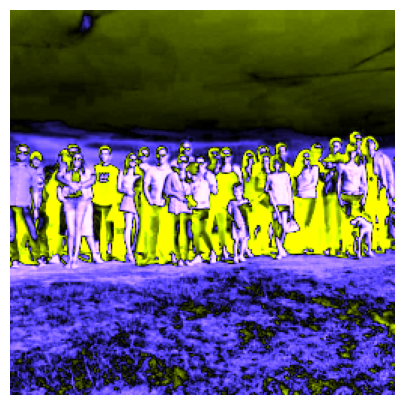

[187771] conv_28x28x1_16x4x4_4x28 ---                , q1                 


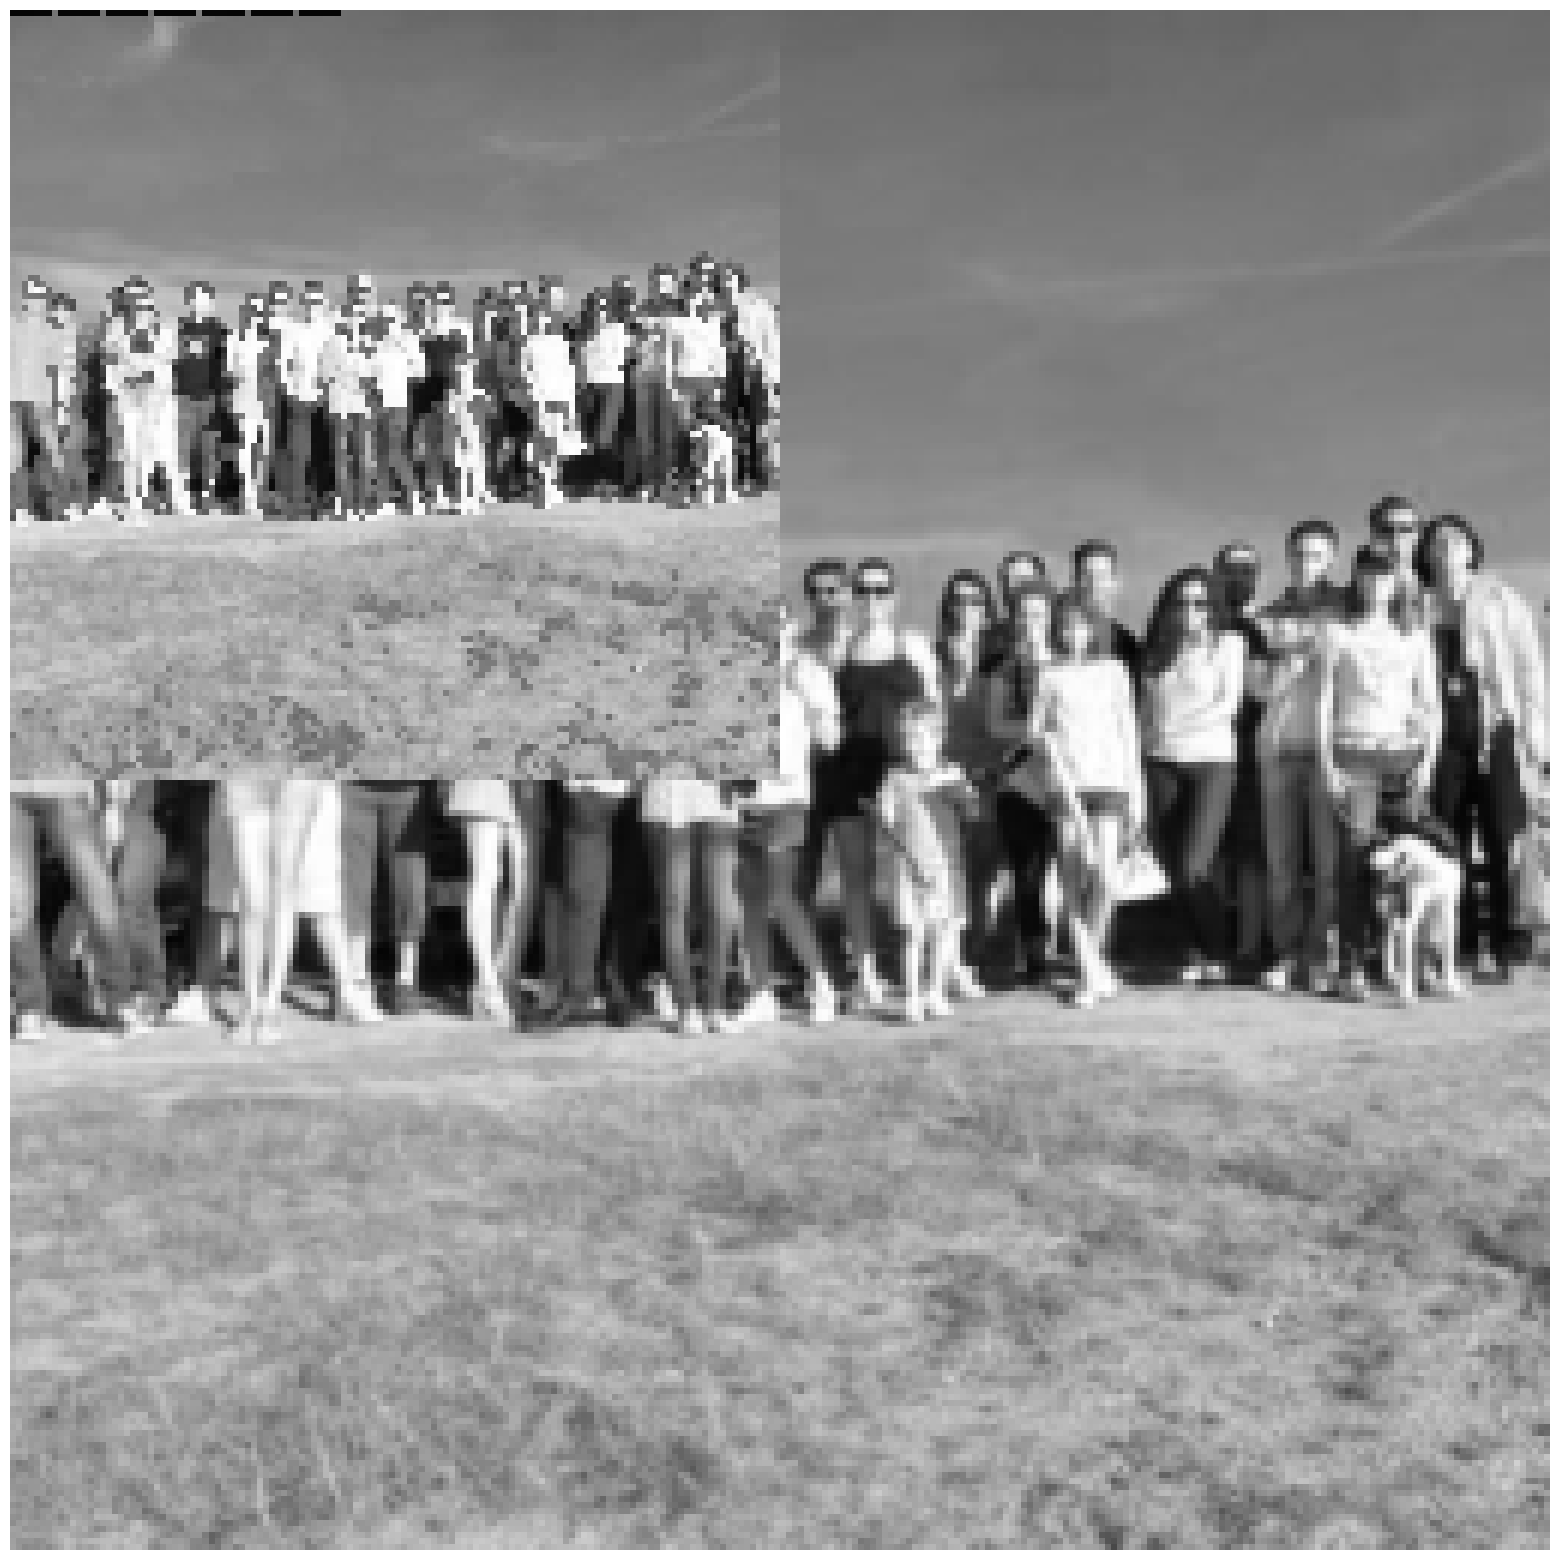

In [17]:
import os
import glob
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
import share.inline as inline

core = CoreInstructionSet()
core.extend(MAC16Option())
core.extend(WindowedRegisterOption())
core.extend(ESP32S3ExtensionOption())

# a8 = load memory offset of vectors
# a9 = store memory offset of vectors
# a10 = number of vectors
# a11 = load memory offset of matrix

files = glob.glob("/home/wipkat/data/widerface/train/images/1*/*.jpg", recursive=True)
image = torchvision.io.read_image(files[13])
image = TF.center_crop(TF.resize(image, 256), 256)[0]
image = image.expand(16,-1,-1)
inline.plot(image, width=5)
image = image.permute(1,2,0)

image_width = 256
image_height = 256
image = image.reshape(-1)
image_size = image.shape[0]
kernel = torch.ones(16,dtype=torch.long)
kernel_size = kernel.shape[0]
memory = torch.cat((image, kernel), -1)
for i, b in enumerate(memory):
    core.memory[i] = b.item() & 0xFF

maxpool_2x2x16 = f"""
xor a8, a8, a8
xor a9, a9, a9
movi a7, {image_height}
movi a6, {image_width}
slli a12, a6, 4
or a13, a12, a12
addi a13, a13, -16
    
max_col:
    movi a6, {image_width}
    or a10, a8, a8
    add a8, a12, a8
    or a11, a9, a9
    addx2 a9, a12, a9
    
max_block:
    ee.vld.128.ip q0, a11, 16
    ee.vld.128.xp q1, a11, a13
    ee.vmax.s8.ld.incp q2, a11, q5, q0, q1
    ee.vmax.s8.ld.incp q3, a11, q6, q5, q2
    sub a11, a11, a12
    ee.vmax.s8 q7, q6, q3
    st.qr q7, a10, 0
    addi a10, a10, 16
    addi a6, a6, -2
    bnez a6, max_block
end_max_block:

    addi a7, a7, -2
    bnez a7, max_col
end_max_col:

"""

shift_right = 15
image = 0
image_width = 28
image_height = 28
image_stride = 32
kernel = image_height*image_stride
output = image

conv_28x28x1_16x4x4 = f"""
movi a6, 16
movi a9, {kernel}
movi a10, {output}
conv_28x28x1_16x4x4_output_channel:
    movi a7, 28
    movi a8, {image}
    or a11, a10, a10
    
conv_28x28x1_16x4x4_4x28:
    ee.vld.128.ip q0, a8, 16
    ee.vld.128.ip q1, a8, 16
    ee.vld.128.ip q2, a8, 16
    ee.vld.128.ip q3, a8, 16
    ee.vld.128.ip q4, a8, 16
    ee.vld.128.ip q5, a8, 16
    ee.vld.128.ip q6, a8, 16
    ee.vld.128.ip q7, a8, 16
    ee.vzip.32 q0,q2
    ee.vzip.32 q1,q3
    ee.vzip.32 q0,q1
    ee.vzip.32 q2,q3
    ee.vzip.32 q4,q6
    ee.vzip.32 q5,q7
    ee.vzip.32 q4,q5
    ee.vzip.32 q6,q7
    ee.vld.128.ip q7, a9, 16
"""

conv_28x28x1_16x4x4 += "".join(f"""
    ee.zero.accx
    ee.vmulas.u8.accx q{i}, q7
    rur a4, ACCX
    srli a4, a4, {shift_right}
    s8i a4, a10, {i*16}
""" for i in range(7))

conv_28x28x1_16x4x4 += f"""
    addi a10, a10, {8*16}
    addi a7, a7, -4
    bnez a7, conv_28x28x1_16x4x4_4x28

    addi a10, a11, 1
    addi a6, a6, -1
    bnez a6, conv_28x28x1_16x4x4_output_channel
"""

#print(conv_28x28x1_16x4x4)
debug = False
core.add_code(maxpool_2x2x16)
core.add_code(conv_28x28x1_16x4x4)
while True:
    if debug:
        core.step()
        continue
    else:
        try: core.step()
        except Exception as e: 
            core.echo()
            image = torch.tensor(core.memory[:16*256*256], dtype=torch.uint8)
            image = image.reshape(256,256,16).permute(2,0,1)
            inline.plot(image[[0]])
            print(e)
            break